In [1]:
import itertools
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tpdm
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('../../data/train.csv')

In [3]:
train_df.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543  
4                   84.8074  
5                  -11.2541  
6                  -11.2548  
7                   84.8093  
8                  -11.2543  
9                   84.8095

In [4]:
train_df['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [5]:
structure_df = pd.read_csv('../../data/structures.csv')

In [6]:
structure_df.describe()

atom_index             x             y             z
count  2.358657e+06  2.358657e+06  2.358657e+06  2.358657e+06
mean   8.757349e+00  9.489178e-02 -3.337381e-01  6.241504e-02
std    5.592487e+00  1.655271e+00  1.989152e+00  1.445870e+00
min    0.000000e+00 -9.234889e+00 -9.933938e+00 -9.134765e+00
25%    4.000000e+00 -8.746097e-01 -1.826156e+00 -8.424896e-01
50%    9.000000e+00  5.183615e-02 -4.035932e-01  1.093207e-02
75%    1.300000e+01  1.116101e+00  1.373660e+00  9.394357e-01
max    2.800000e+01  9.382240e+00  1.018196e+01  7.894733e+00

In [7]:
structure_df.head(10)

molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397
5  dsgdb9nsd_000002           0    N -0.040426  1.024108  0.062564
6  dsgdb9nsd_000002           1    H  0.017257  0.012545 -0.027377
7  dsgdb9nsd_000002           2    H  0.915789  1.358745 -0.028758
8  dsgdb9nsd_000002           3    H -0.520278  1.343532 -0.775543
9  dsgdb9nsd_000003           0    O -0.034360  0.977540  0.007602

In [8]:
structure_df['atom'].unique()

array(['C', 'H', 'N', 'O', 'F'], dtype=object)

In [9]:
atom_edge = {'H':1, 'F':1, 'O':2, 'N':3, 'C':4}
atom_color = {'C':'c', 'H':'r', 'N':'b', 'O':'y', 'F':'m'}

In [10]:
structure_df.values

array([['dsgdb9nsd_000001', 0, 'C', -0.012698135900000001, 1.085804158,
        0.008000995799999999],
       ['dsgdb9nsd_000001', 1, 'H', 0.002150416, -0.0060313176,
        0.0019761204],
       ['dsgdb9nsd_000001', 2, 'H', 1.011730843, 1.4637511619999999,
        0.0002765748],
       ...,
       ['dsgdb9nsd_133885', 13, 'H', 2.5158540609999998, -1.151783773,
        0.5273692559000001],
       ['dsgdb9nsd_133885', 14, 'H', 0.0136988019, 1.19943057,
        -1.680192303],
       ['dsgdb9nsd_133885', 15, 'H', 1.260745327, -1.246753647,
        -1.906767156]], dtype=object)

In [11]:
structures = []
structure = []
prev_name = structure_df["molecule_name"][0]
for molecule_name, atom_index, atom, x, y, z in structure_df.values:
    if molecule_name != prev_name:
        structure = np.asarray(structure, dtype=object)
        structures.append(structure)
        structure = []        
    structure.append([atom, x, y, z])
    prev_name = molecule_name
structures.append(structure)

In [12]:
structures[0]

array([['C', -0.012698135900000001, 1.085804158, 0.008000995799999999],
       ['H', 0.002150416, -0.0060313176, 0.0019761204],
       ['H', 1.011730843, 1.4637511619999999, 0.0002765748],
       ['H', -0.540815069, 1.447526614, -0.8766437152],
       ['H', -0.5238136345000001, 1.437932644, 0.9063972942]],
      dtype=object)

# https://www.kaggle.com/asauve/dataset-with-number-of-bonds-between-atoms/notebook
# expected distances in [A] for covalence 1 bond
BOND_DIST_C1 = { 'C' : 0.77, 'H' : 0.38, 'N' : 0.75, 'O' : 0.73, 'F' : 0.71 }

In [13]:
class named_structure(object):
    def __init__(self, atom, pos, edge_num):
        self.atom = atom
        self.pos = pos
        self.edge_num = edge_num
        self.edges = []

In [14]:
def calc_neighbors(pos0, pos1):
    distances = np.sum((pos1 - pos0)**2, axis=1)
    sort_neighbors = np.asarray(sorted([[i, d] for i, d in enumerate(distances)], key=lambda x: x[1]))
    neighbors = sort_neighbors.T[0][sort_neighbors.T[1] != 0]
    return neighbors

In [15]:
import copy
def get_edges(structure):
    named_structures = dict()
    id2name = dict()
    name2id = dict()
    atom_count = {atom:0 for atom in atom_color.keys()}
    for i, st in enumerate(structure):
        atom, pos = st[0], st[1:]    
        named_structures[atom+str(atom_count[atom])] = named_structure(atom, pos, atom_edge[atom])
        id2name[i] = atom+str(atom_count[atom])
        name2id[atom+str(atom_count[atom])] = i
        atom_count[atom] += 1
    
    neigbor_atoms = {}
    need_edge = sum([atom_edge[atom]*num for atom, num in atom_count.items()])
    # 最近傍の適用順序．全組み合わせを計算
    atom_base = [atom+str(i) for atom in ['H', 'F'] for i in range(atom_count[atom]) if atom_count[atom] != 0]
    atom_series = [atom+str(i) for atom in ['O', 'N', 'C'] for i in range(atom_count[atom]) if atom_count[atom] != 0]
    edges = np.zeros((len(structure), len(structure)))
    patterns = [pat for pat in itertools.permutations(atom_series)]
    save_structures = copy.deepcopy(named_structures)
    for pattern in patterns:
        base = copy.copy(atom_base)
        base.extend(list(pattern))
        pattern = base
        
        edges[:, :] = 0
        cand_edges = []
        named_structures = copy.deepcopy(save_structures)
        try:
            change = 0
            while need_edge != np.sum(edges):
                for name in pattern:
                    pos = named_structures[name].pos
                    edge_num = named_structures[name].edge_num
                    if edge_num != 0:
                        neighbors = calc_neighbors(pos, structure[:, 1:])
                        neighbor_name = None
                        for i in neighbors:
                            if named_structures[id2name[i]].edge_num != 0:
                                neighbor_name = id2name[i]
                                break
                        #print(edges)
                        named_structures[name].edge_num -= 1
                        named_structures[neighbor_name].edge_num -= 1
                        edges[name2id[neighbor_name]][name2id[name]] += 1
                        edges[name2id[name]][name2id[neighbor_name]] += 1
                        cand_edges.append([name2id[name], name2id[neighbor_name]])
                        change += 1
                if change == 0:
                    break
        except:
            pass
        
        if need_edge == np.sum(edges):
            print(need_edge, np.sum(edges))
            tree_check = set(cand_edges[0])
            while True:
                change = 0
                for edge in cand_edges[1:]:
                    edge = set(edge)
                    if len(tree_check & edge) == 1:
                        tree_check = tree_check | set(edge)
                        change += 1

                if change == 0:
                    break
            
            if len(structure) == len(tree_check):
                break
    
    return (named_structures, name2id, id2name, edges, atom_count)

#15, 19, 32, 68, 88---
get_edges(structures[92])

26 26.0
26 26.0
26 26.0


({'O0': <__main__.named_structure at 0x7ff929191ba8>,
  'C0': <__main__.named_structure at 0x7ff929191ac8>,
  'C1': <__main__.named_structure at 0x7ff9291919e8>,
  'C2': <__main__.named_structure at 0x7ff929191908>,
  'C3': <__main__.named_structure at 0x7ff929191828>,
  'H0': <__main__.named_structure at 0x7ff93075e080>,
  'H1': <__main__.named_structure at 0x7ff93075e0f0>,
  'H2': <__main__.named_structure at 0x7ff93075e160>,
  'H3': <__main__.named_structure at 0x7ff93075e1d0>,
  'H4': <__main__.named_structure at 0x7ff93075e240>,
  'H5': <__main__.named_structure at 0x7ff93075e2b0>,
  'H6': <__main__.named_structure at 0x7ff93075e320>,
  'H7': <__main__.named_structure at 0x7ff93075e390>},
 {'O0': 0,
  'C0': 1,
  'C1': 2,
  'C2': 3,
  'C3': 4,
  'H0': 5,
  'H1': 6,
  'H2': 7,
  'H3': 8,
  'H4': 9,
  'H5': 10,
  'H6': 11,
  'H7': 12},
 {0: 'O0',
  1: 'C0',
  2: 'C1',
  3: 'C2',
  4: 'C3',
  5: 'H0',
  6: 'H1',
  7: 'H2',
  8: 'H3',
  9: 'H4',
  10: 'H5',
  11: 'H6',
  12: 'H7'},
 ar

In [16]:
np.all(np.arange(5)!=-1)

True

In [17]:
structures[15]

array([['C', 0.0153771978, 1.4176438, 0.0095628663],
       ['C', 1.264781612, 0.6492398384, -0.0065504377],
       ['O', -0.00024017880000000002, -0.007710059, 0.0020405474],
       ['H', -0.31763326350000004, 1.88586598, 0.9347575102],
       ['H', -0.3352758293, 1.895766733, -0.9039757823000001],
       ['H', 1.83246682, 0.5625684765, -0.9319329026000001],
       ['H', 1.850082582, 0.5526793813, 0.9068014687999999]], dtype=object)

8 8.0


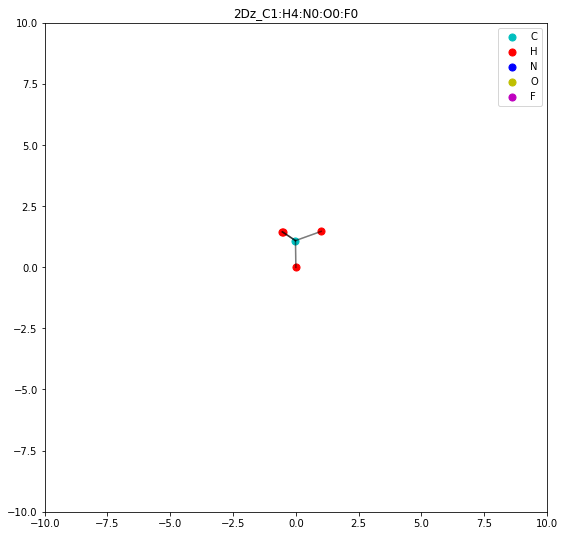

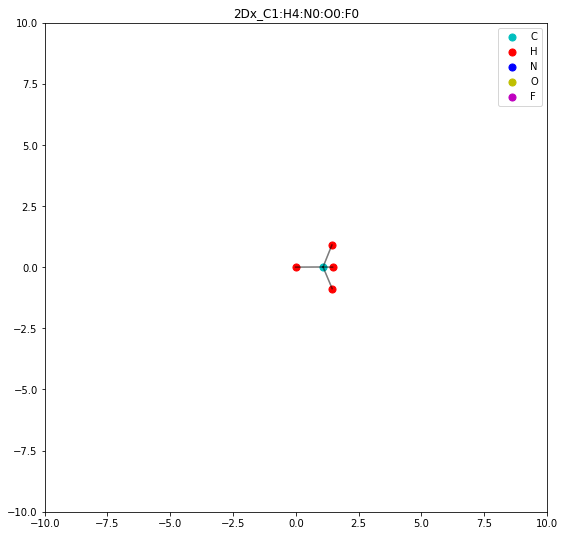

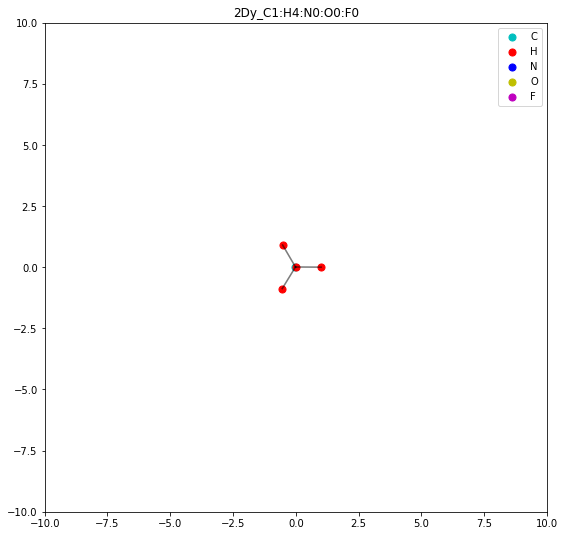

In [18]:
def print_2Dstructure(structure, name2id, id2name, edges, atom_count, direct='z', figsize=(9, 9), scale=5, plot=True, save=True):
    """
    structure: 化合物の情報 ([atom, x, y, z] からなるリスト)
    direct: どの角度から見るか ('x', 'y', 'z' のいずれか)
    figsize: 画像サイズ ([x, y])
    scale: lim のサイズ (int)
    plot: plot するかしないか
    save: save するかしないか
    """
    # 全て plot されても邪魔なので
    if plot:
        %matplotlib inline
    else:
        # 最後の図だけは表示されてしまう
        %matplotlib agg
    
    save_folder = '../../data/2D_image'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    plt.figure(figsize=figsize)
    for atom_name, named_structure in structure.items():
        atom = named_structure.atom
        x, y, z = named_structure.pos
        if direct == 'z':
            for i, e in enumerate(edges[name2id[atom_name]]):
                if e >= 1:
                    nx, ny, nz = structure[id2name[i]].pos
                    plt.plot([x, nx], [y, ny], color='black', alpha=e*0.3)
            plt.scatter(x, y, color=atom_color[atom], s=50)
        elif direct == 'x':
            for i, e in enumerate(edges[name2id[atom_name]]):
                if e >= 1:
                    nx, ny, nz = structure[id2name[i]].pos
                    plt.plot([y, ny], [z, nz], color='black', alpha=e*0.3)
            plt.scatter(y, z, color=atom_color[atom], s=50)
        elif direct == 'y':
            for i, e in enumerate(edges[name2id[atom_name]]):
                if e >= 1:
                    nx, ny, nz = structure[id2name[i]].pos
                    plt.plot([x, nx], [z, nz], color='black', alpha=e*0.3)
            plt.scatter(x, z, color=atom_color[atom], s=50)

    filename = '2D'+direct+ '_' + ":".join([str(atom)+str(num) for atom, num in atom_count.items()])
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title(filename)
    handles=[plt.scatter([], [], color=c, s=50) for c in atom_color.values()]
    plt.legend(handles=handles, labels=atom_color.keys())
    
    if save:
        plt.savefig(os.path.join(save_folder, filename))
    
    
    if plot:
        plt.show()

structure, name2id, id2name, edges, atom_count = get_edges(structures[0])
print_2Dstructure(structure, name2id, id2name, edges, atom_count, 'z')
print_2Dstructure(structure, name2id, id2name, edges, atom_count, 'x', plot=True)
print_2Dstructure(structure, name2id, id2name, edges, atom_count, 'y', plot=False)

32 32.0
[[0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


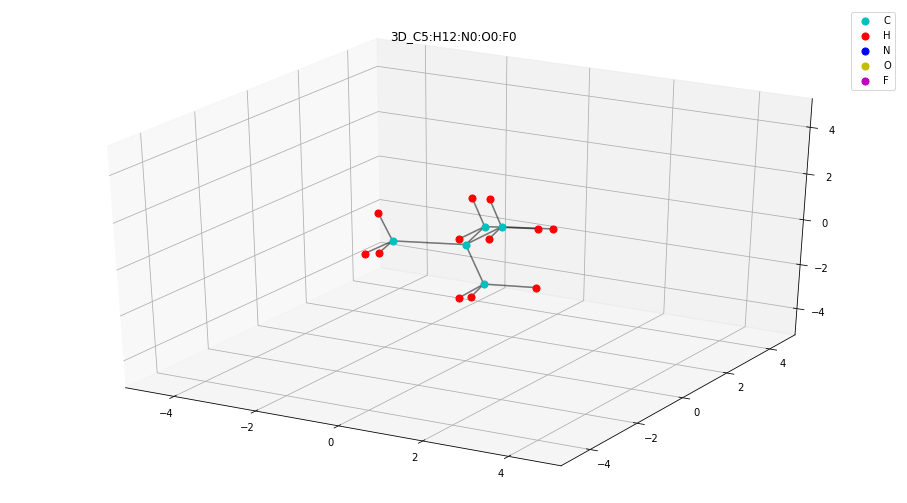

In [19]:
def print_3Dstructure(structure, name2id, id2name, edges, atom_count, figsize=(9, 9), scale=5, plot=True, save=True):
    
    # 全て plot されても邪魔なので
    if plot:
        %matplotlib inline
    else:
        # 最後の図だけは表示されてしまう
        %matplotlib agg
        
    save_folder = '../../data/3D_image'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    for atom_name, named_structure in structure.items():
        atom = named_structure.atom
        x, y, z = named_structure.pos
        
        for i, e in enumerate(edges[name2id[atom_name]]):
            if e >= 1:
                nx, ny, nz = structure[id2name[i]].pos
                plt.plot([x, nx], [y, ny], [z, nz], color='black', alpha=e*0.3)
        ax.scatter(x, y, z, color=atom_color[atom], s=50)
    filename = '3D_' + ":".join([str(atom)+str(num) for atom, num in atom_count.items()])
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_zlim(-scale, scale)
    ax.set_title(filename)
    handles=[ax.scatter([], [], [], color=c, s=50) for c in atom_color.values()]
    ax.legend(handles=handles, labels=atom_color.keys())
    
    if save:
        plt.savefig(os.path.join(save_folder, filename))
    
    
    if plot:
        plt.show()

structure, name2id, id2name, edges, atom_count = get_edges(structures[51])
print(edges)
print_3Dstructure(structure, name2id, id2name, edges, atom_count)

0
8 8.0


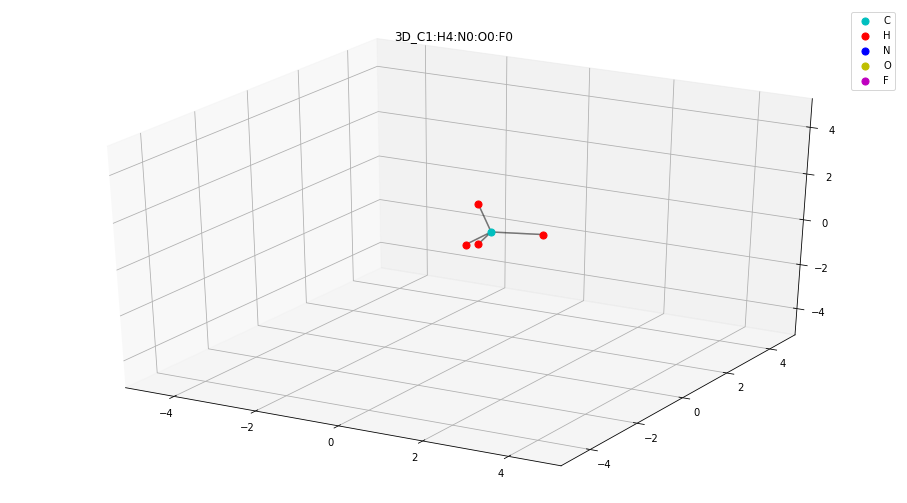

1
6 6.0


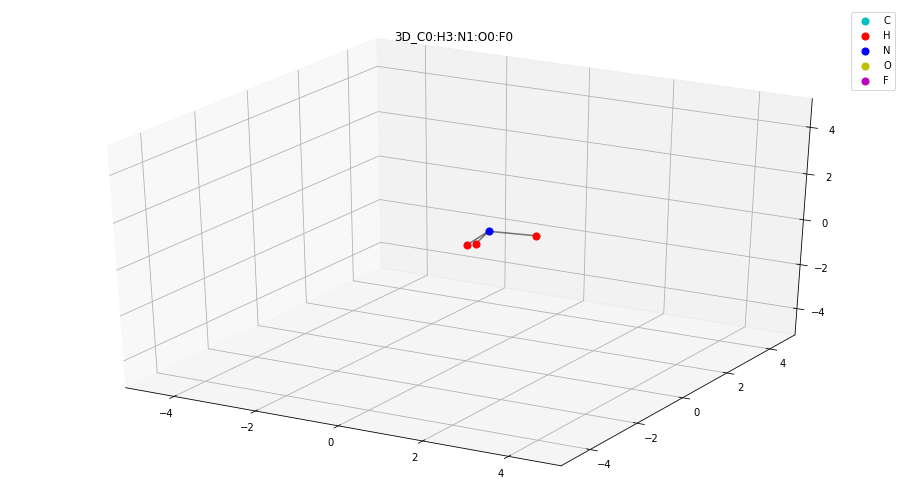

2
4 4.0


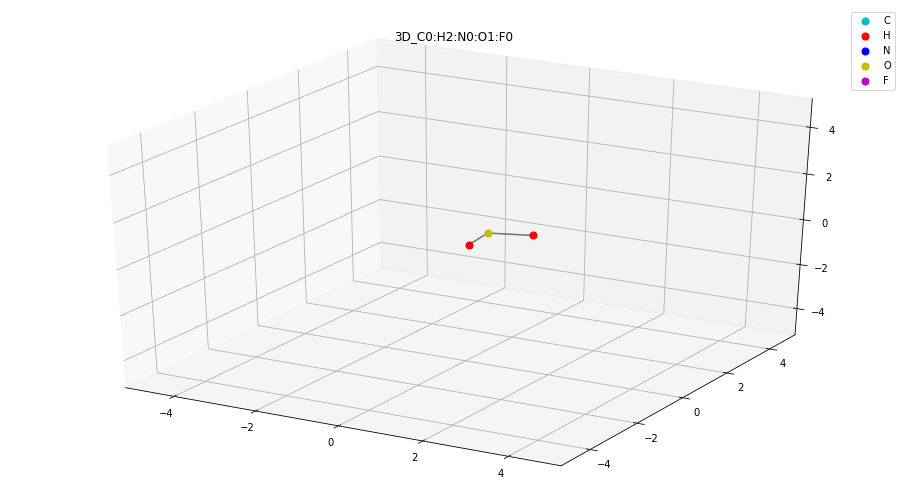

3
10 10.0


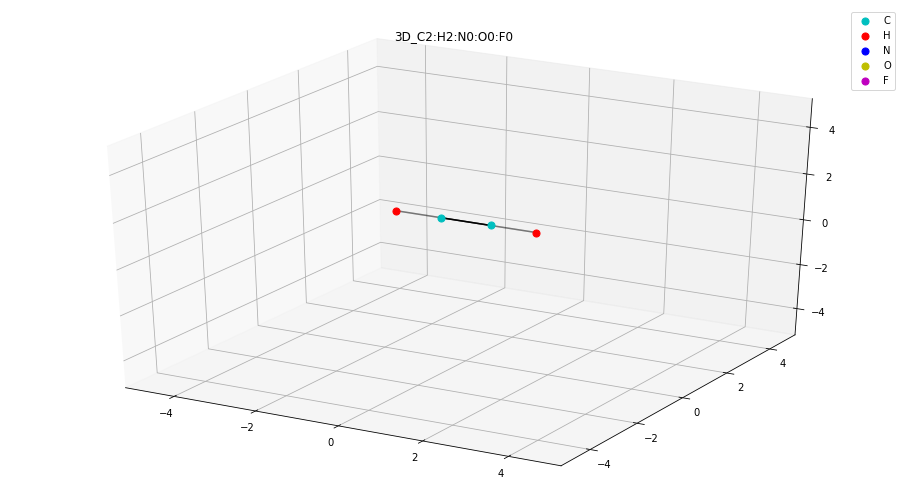

4
8 8.0


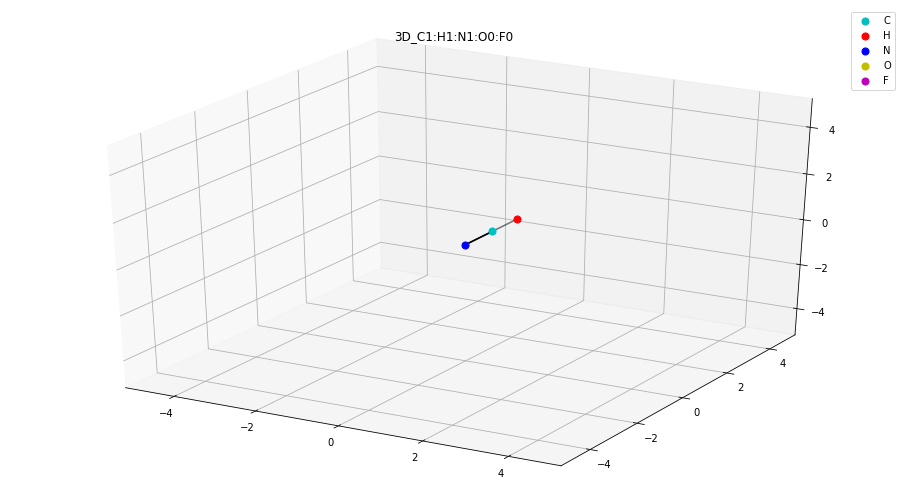

5
14 14.0


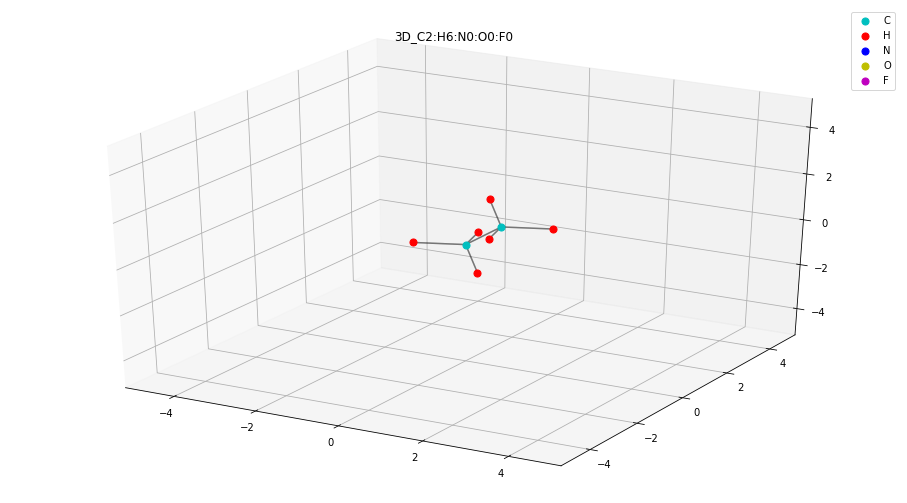

6
10 10.0


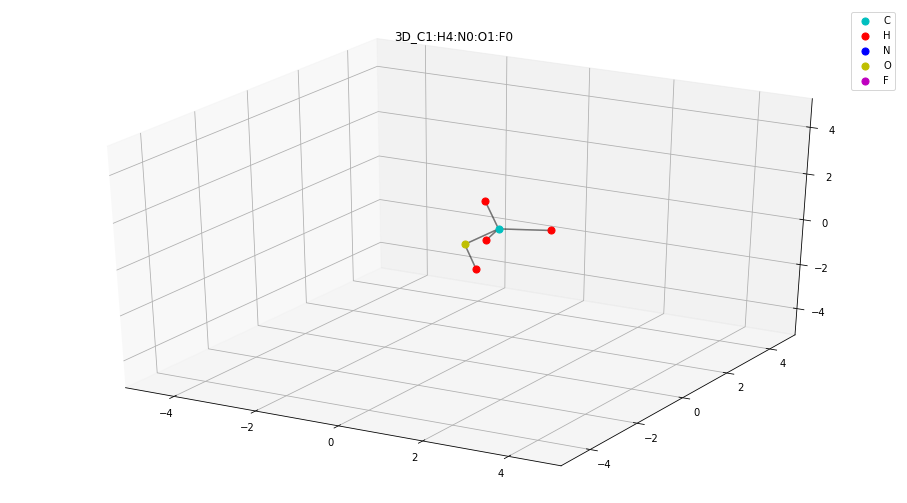

7
16 16.0


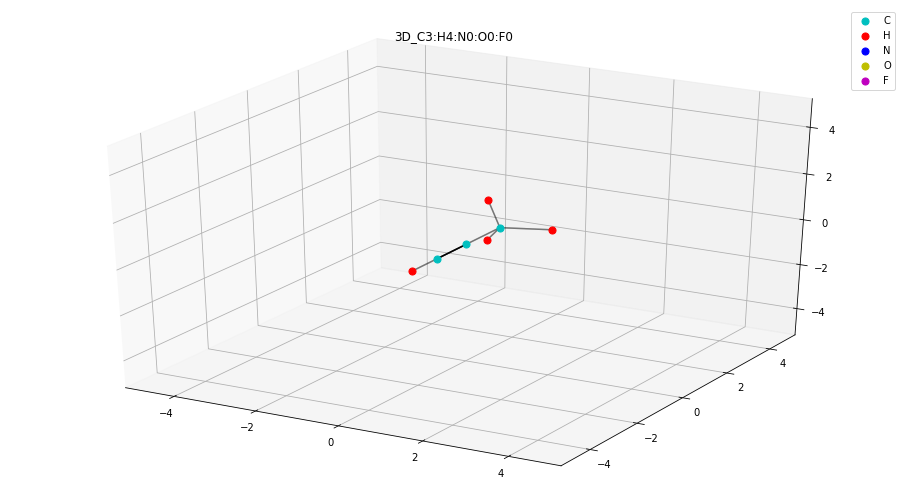

8
14 14.0


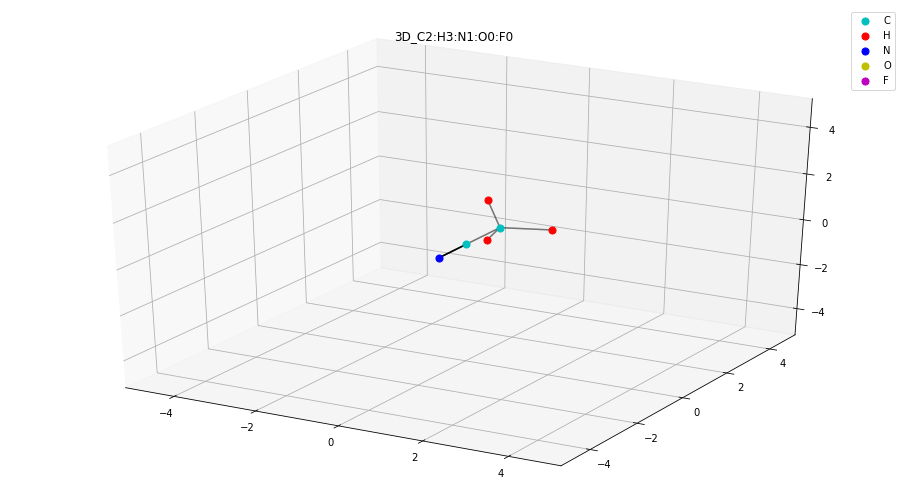

9
14 14.0


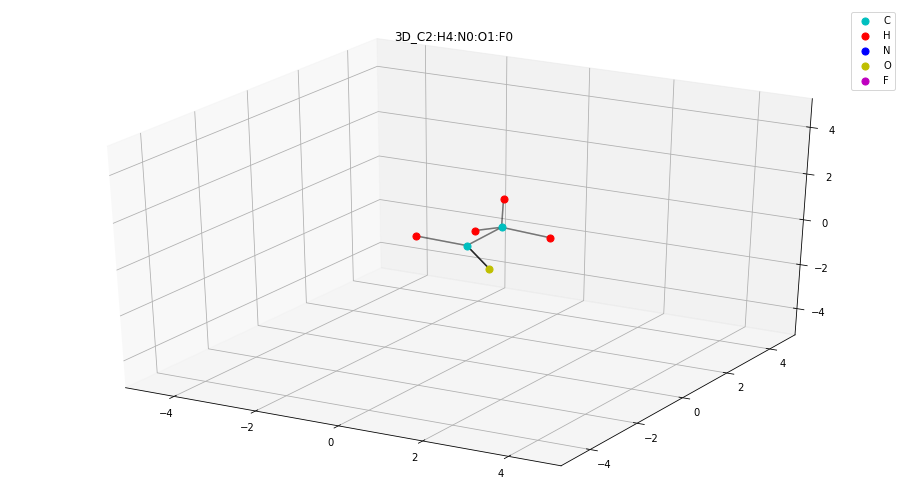

10
12 12.0


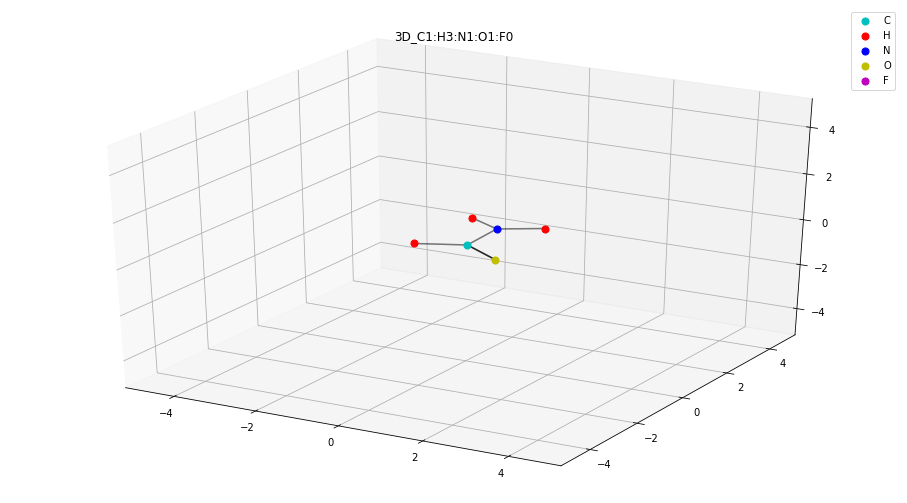

11
20 20.0


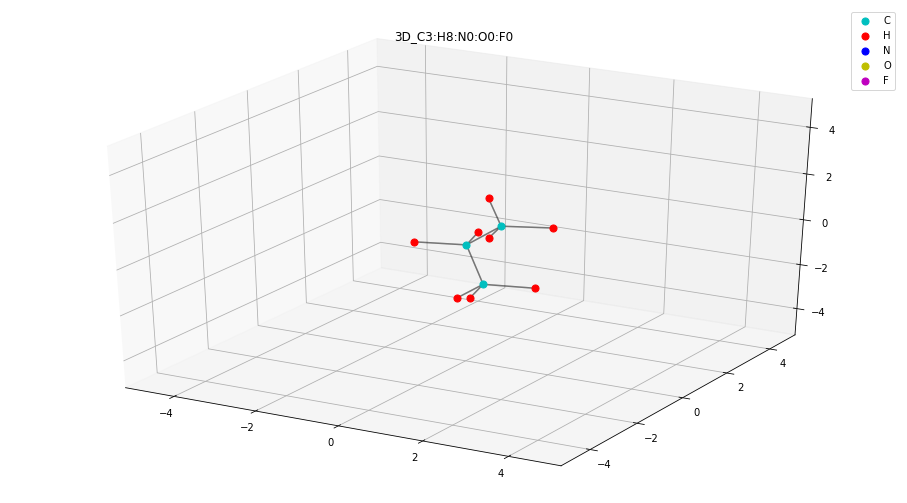

12
16 16.0


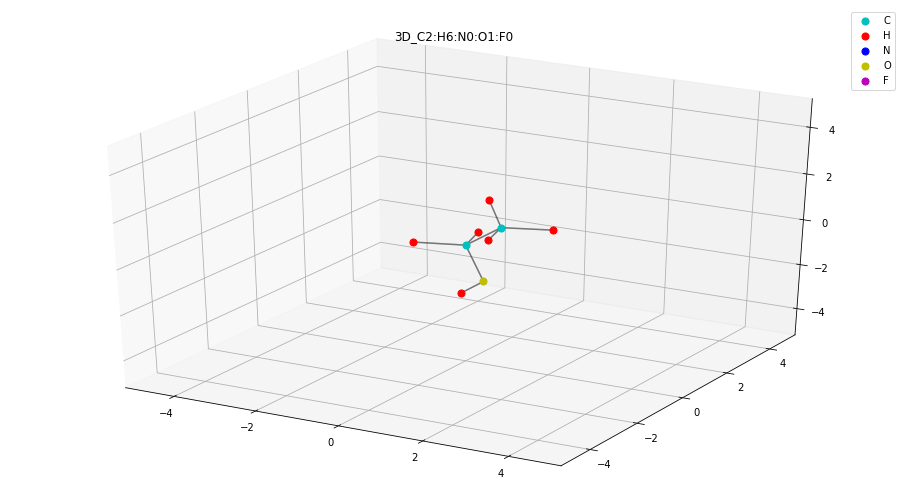

13
16 16.0


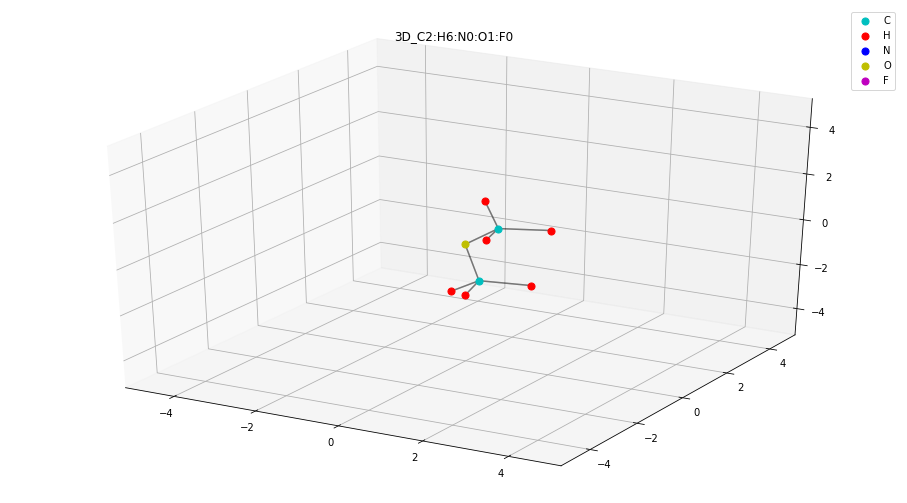

14
18 18.0


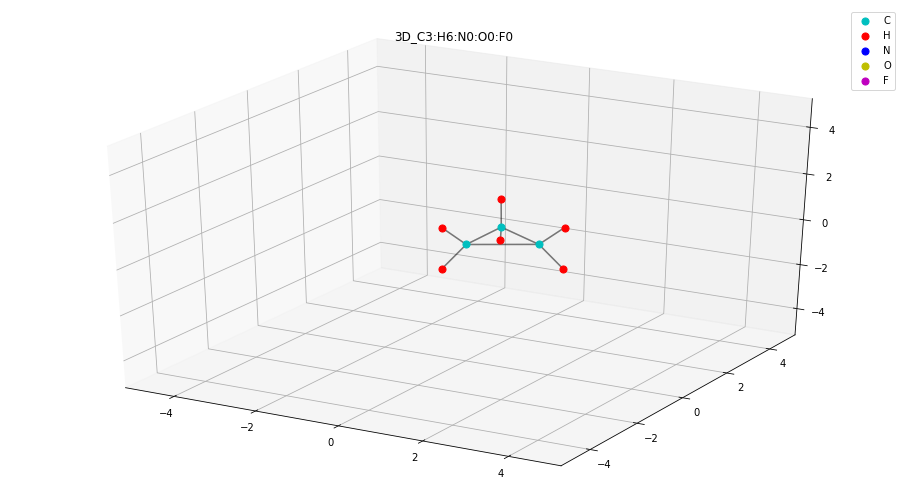

15
14 14.0


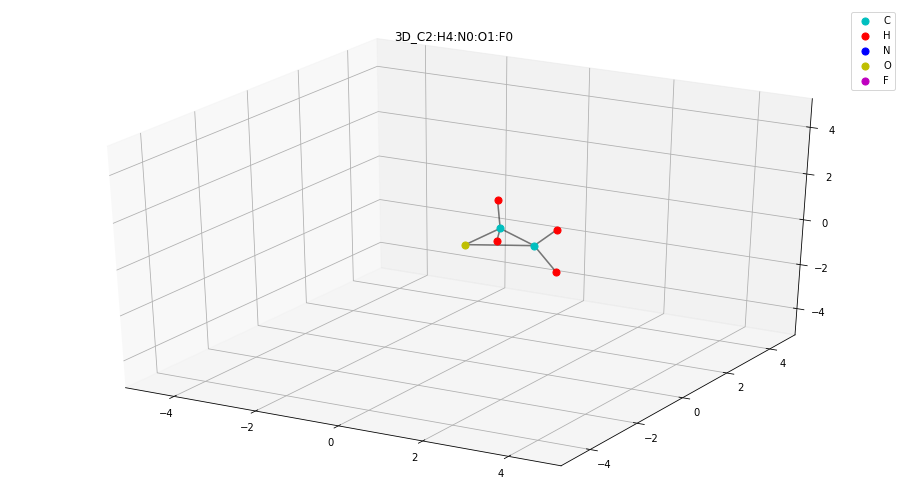

16
20 20.0


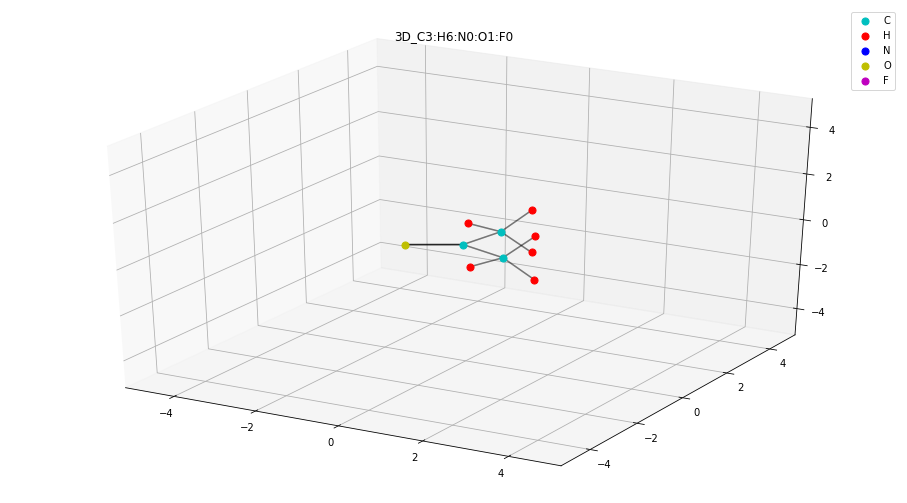

17
18 18.0


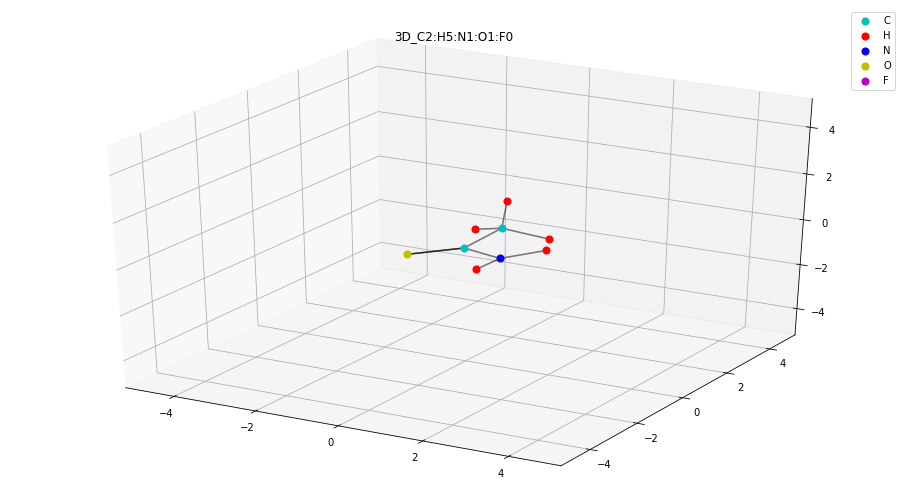

18
16 16.0


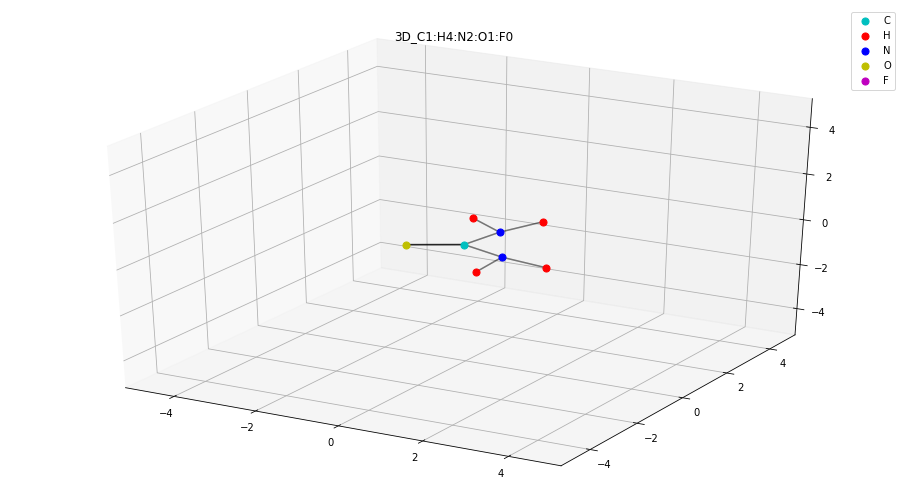

19
26 26.0


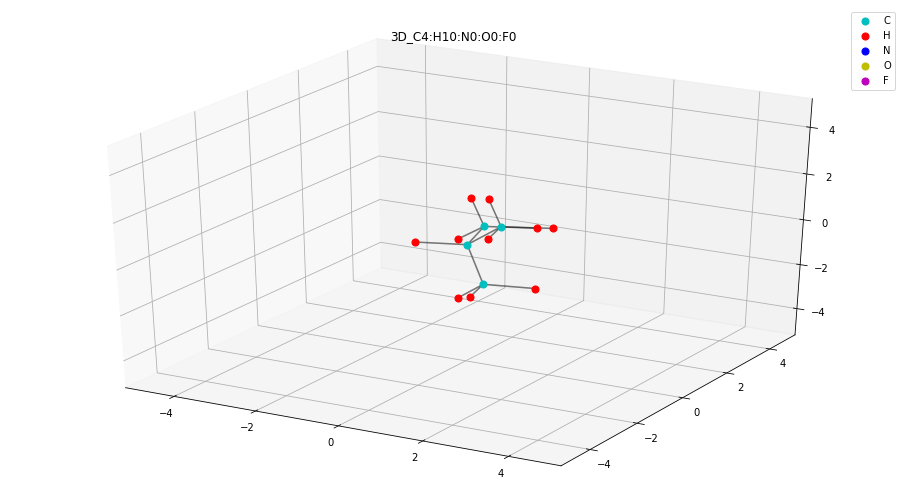

20
22 22.0


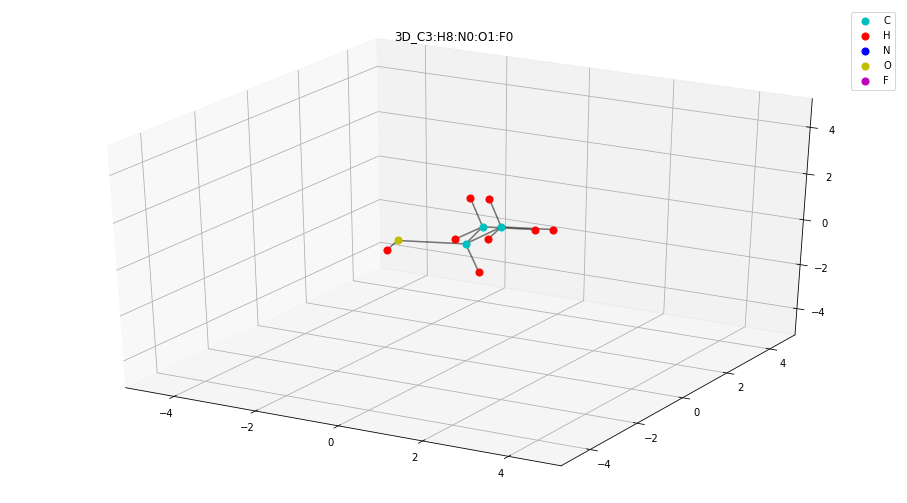

21
18 18.0


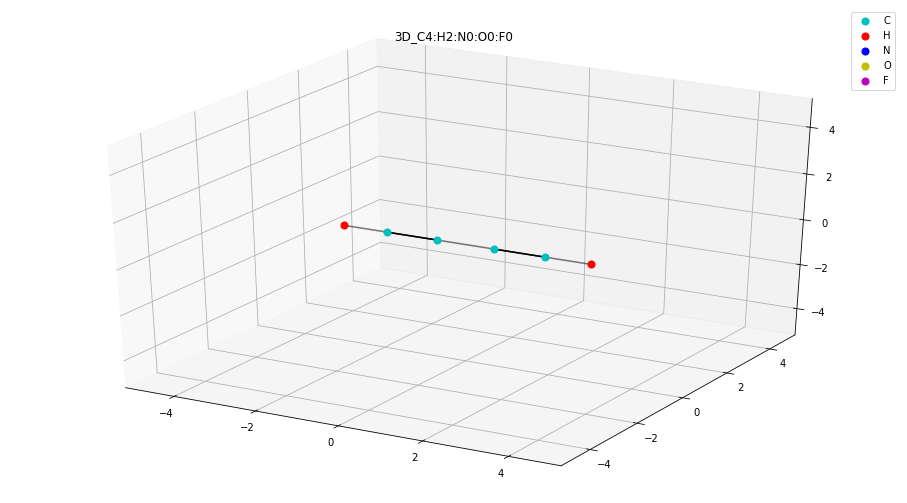

22
16 16.0


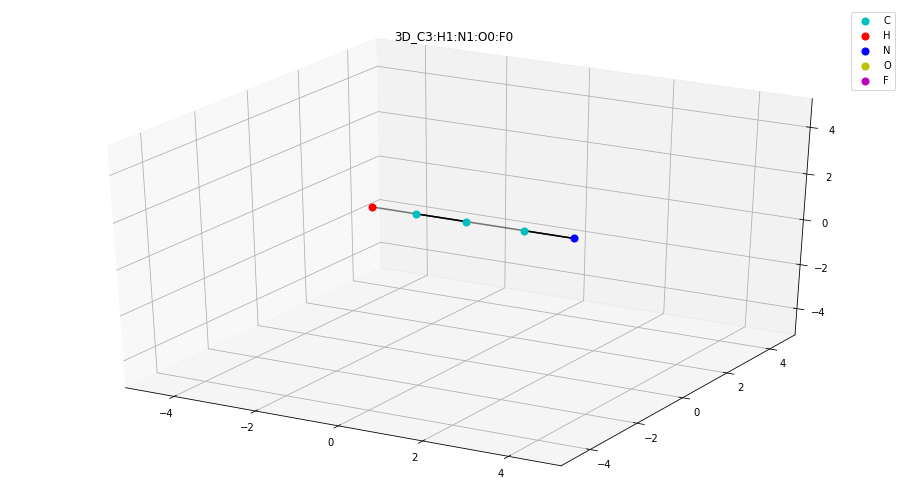

23
16 16.0


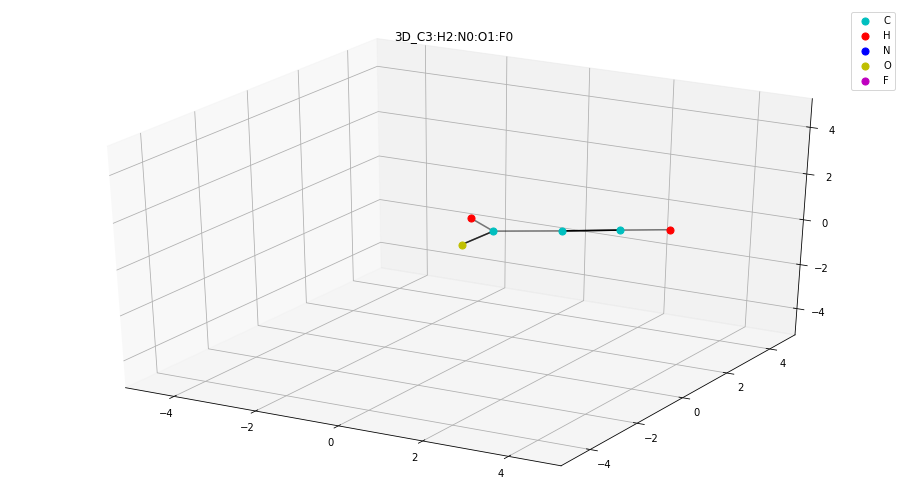

24
14 14.0


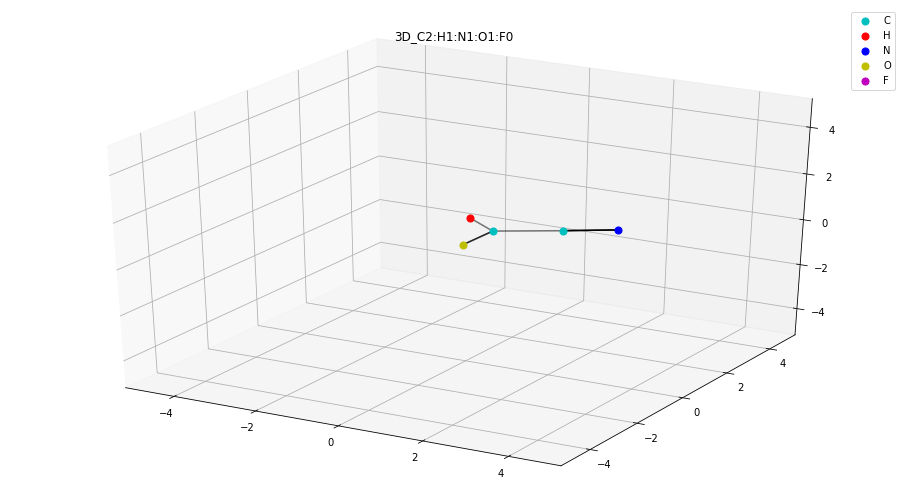

25
14 14.0


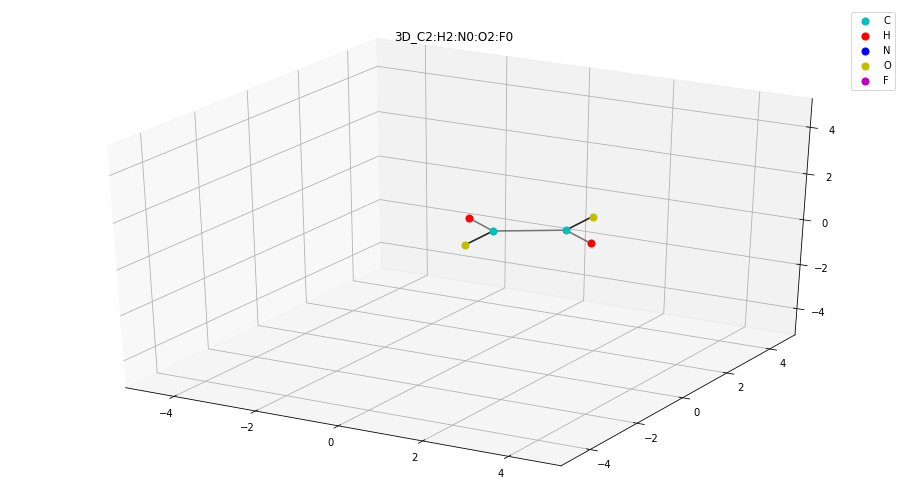

26
22 22.0


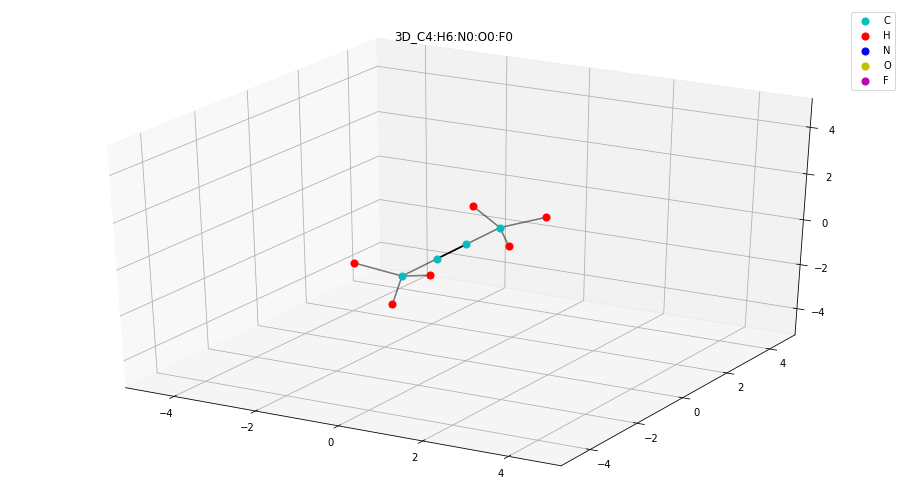

27
22 22.0


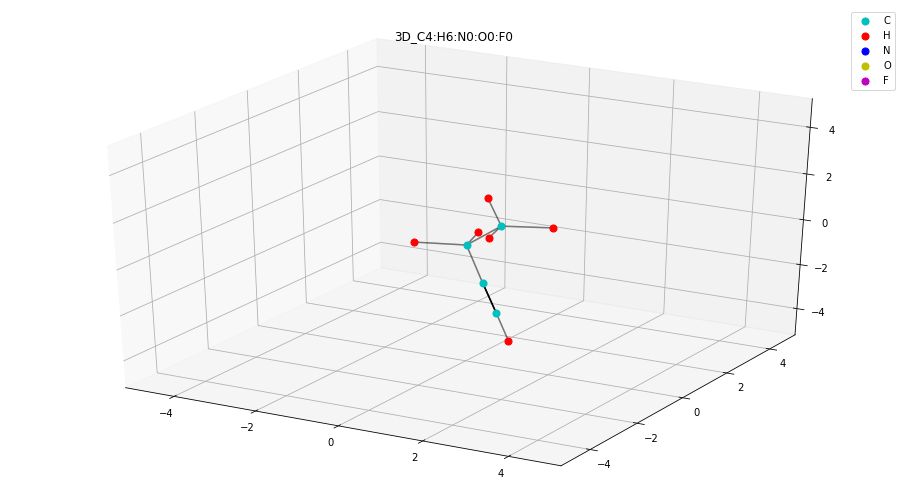

28
20 20.0


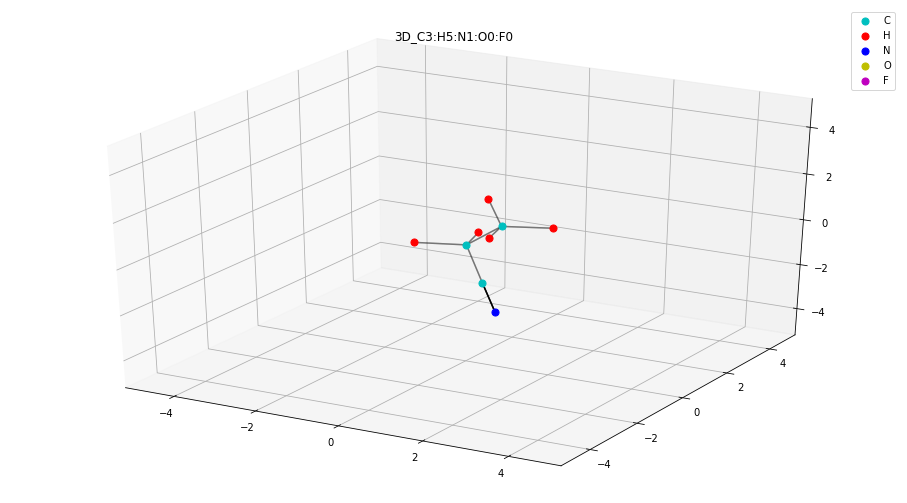

29
18 18.0


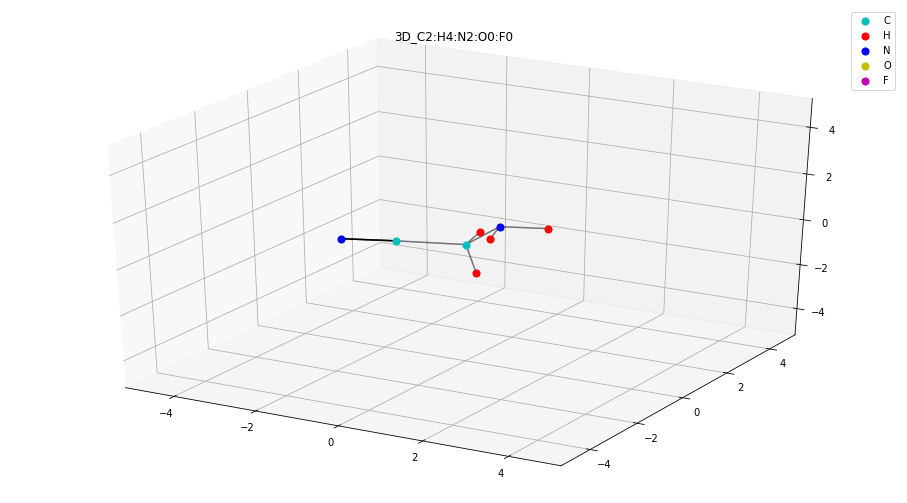

30
18 18.0


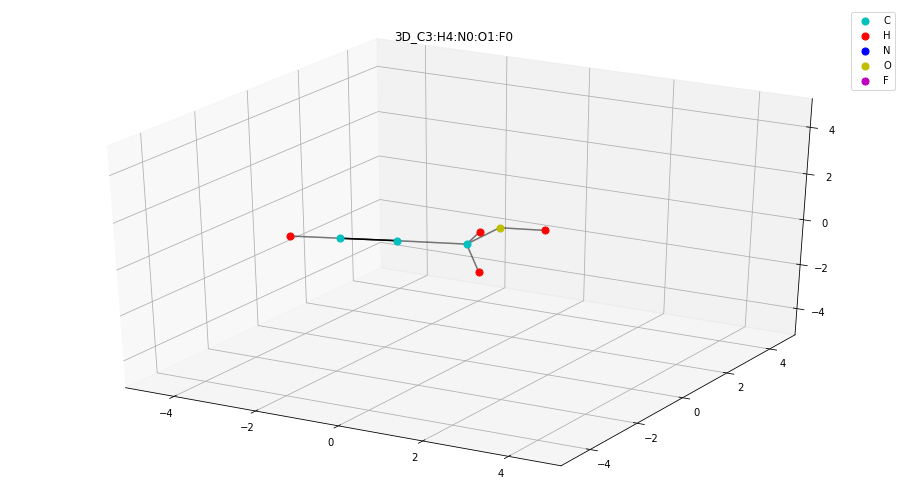

31
16 16.0


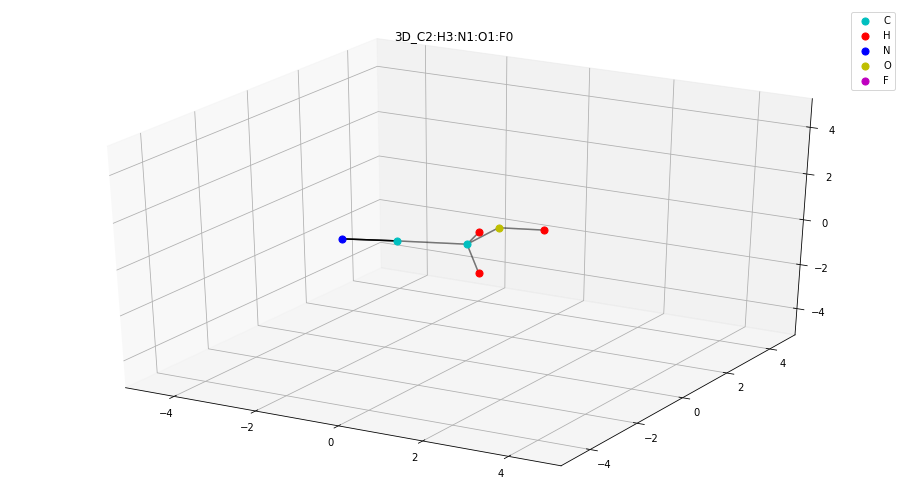

32
20 20.0


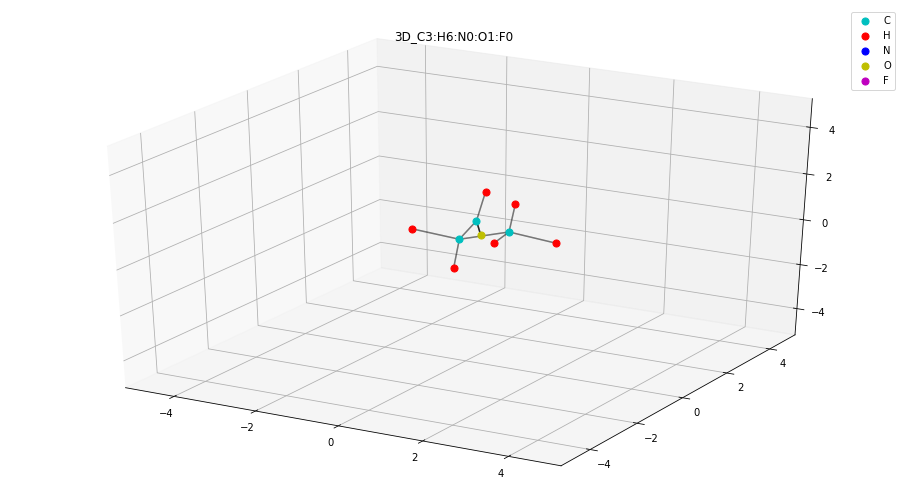

33
18 18.0


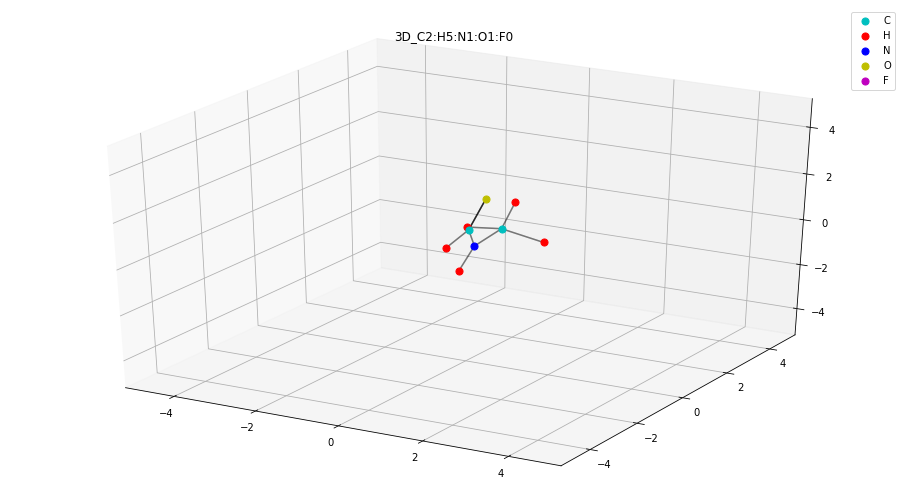

34
16 16.0


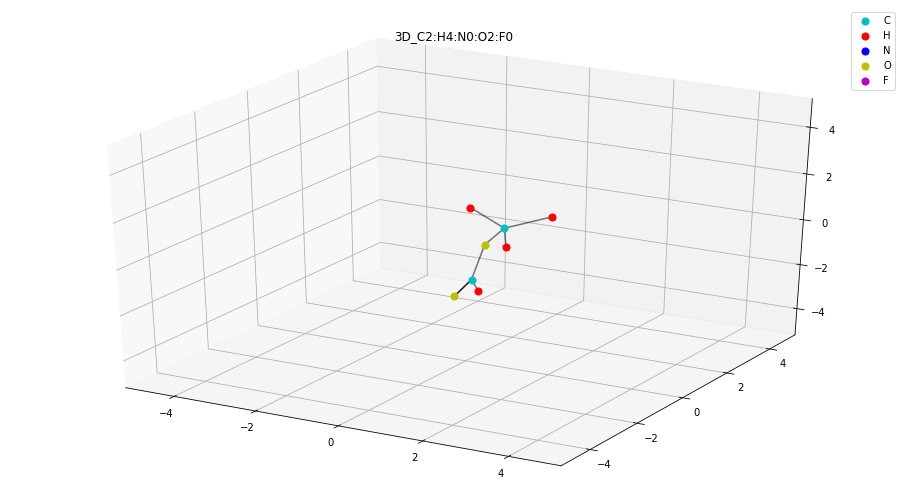

35
16 16.0


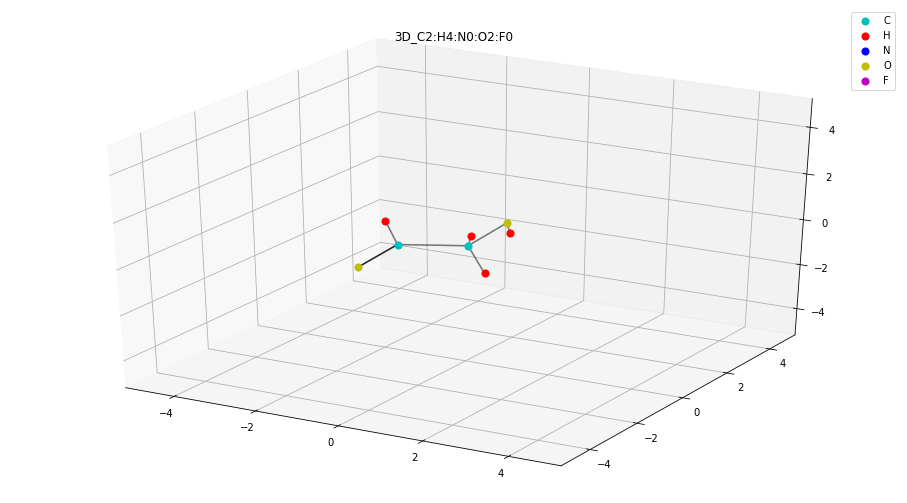

36
26 26.0


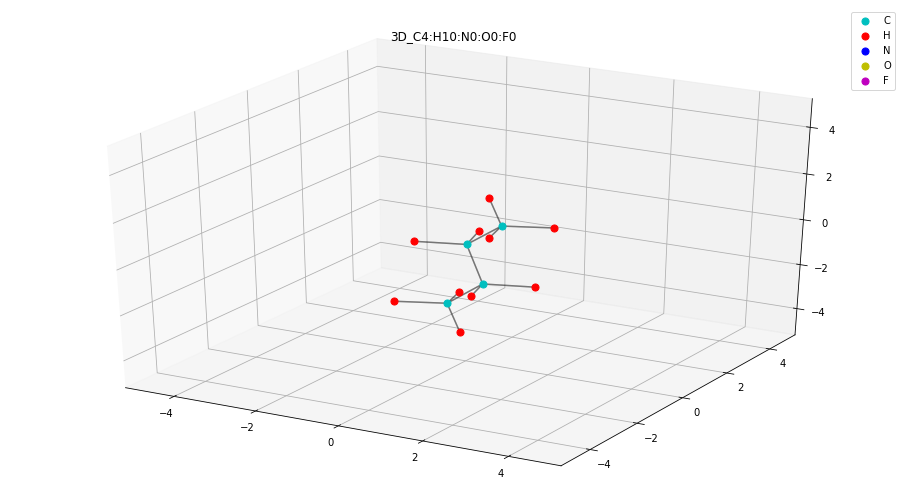

37
22 22.0


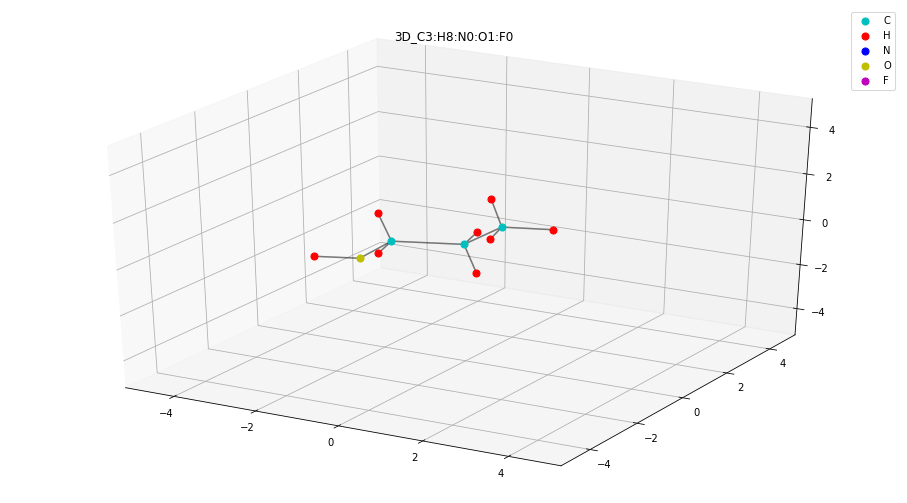

38
22 22.0


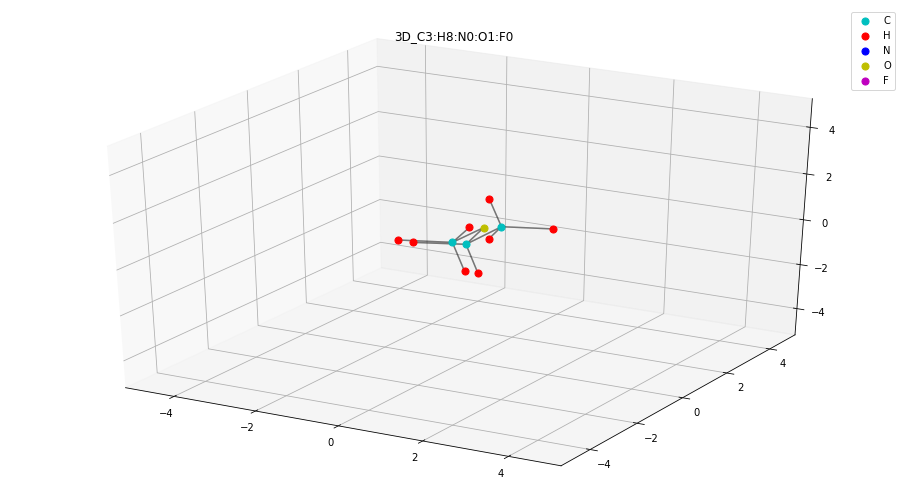

39
18 18.0


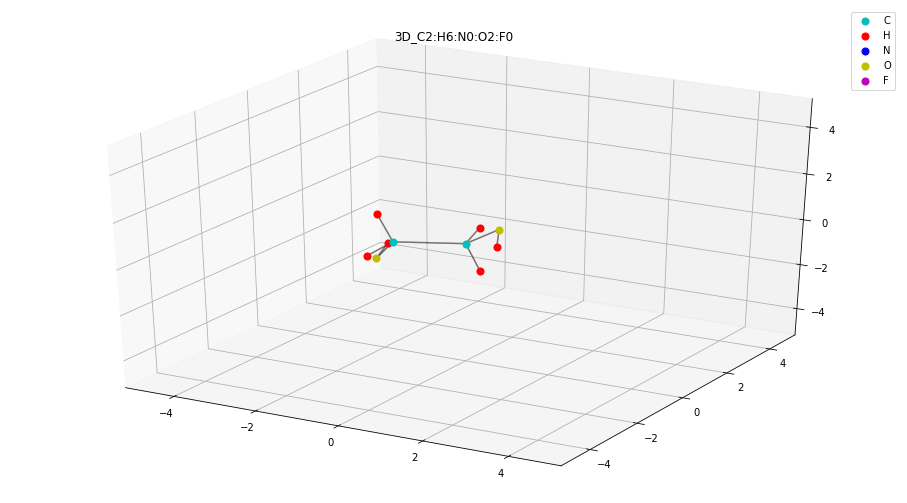

40
24 24.0


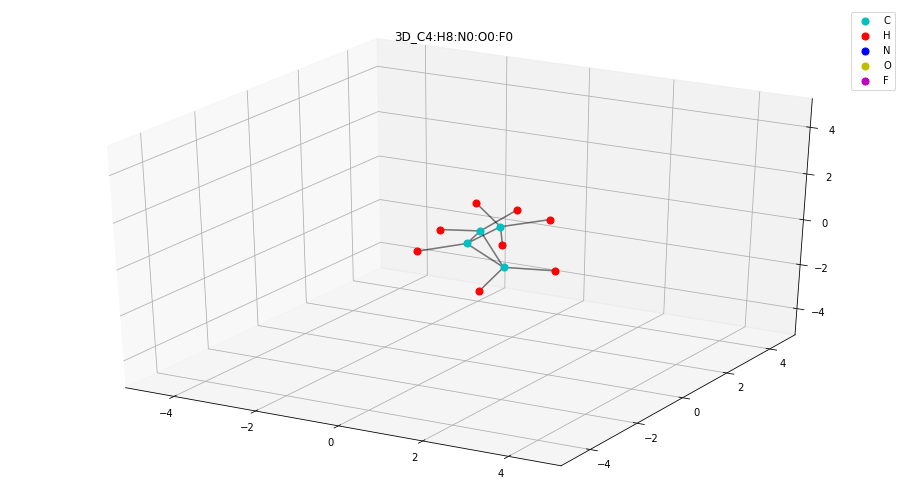

41
20 20.0


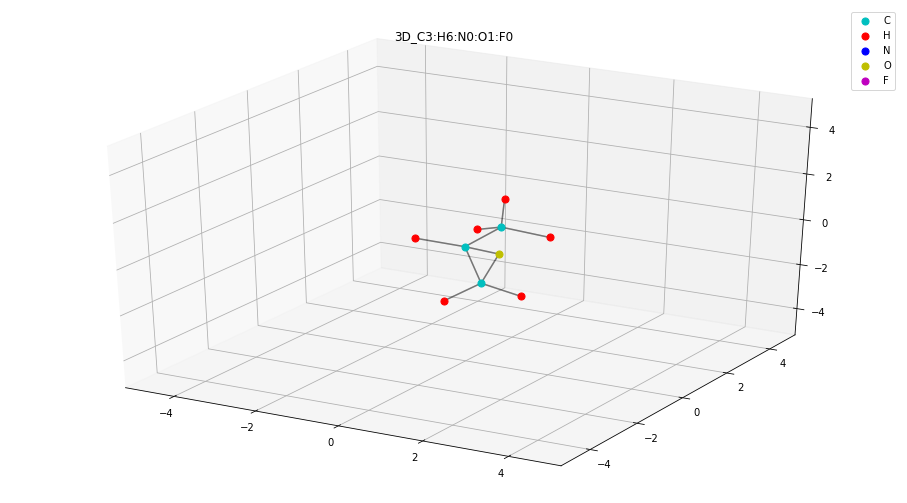

42
22 22.0


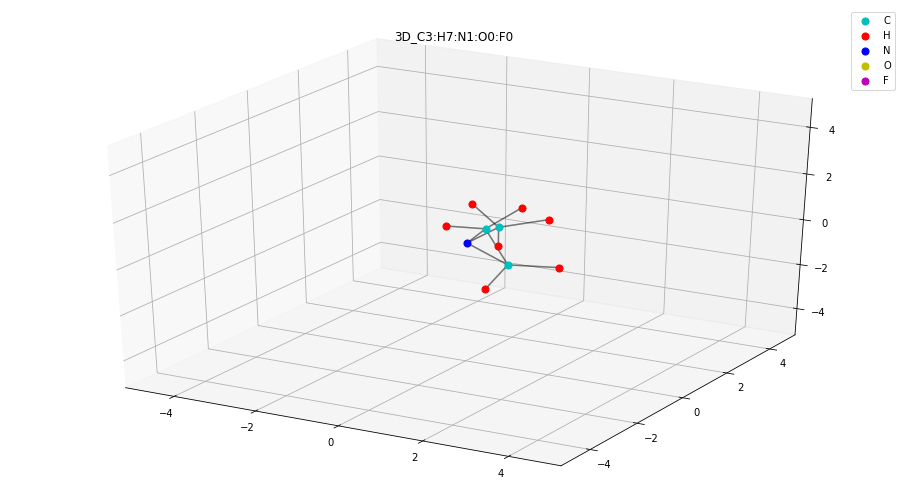

43
20 20.0


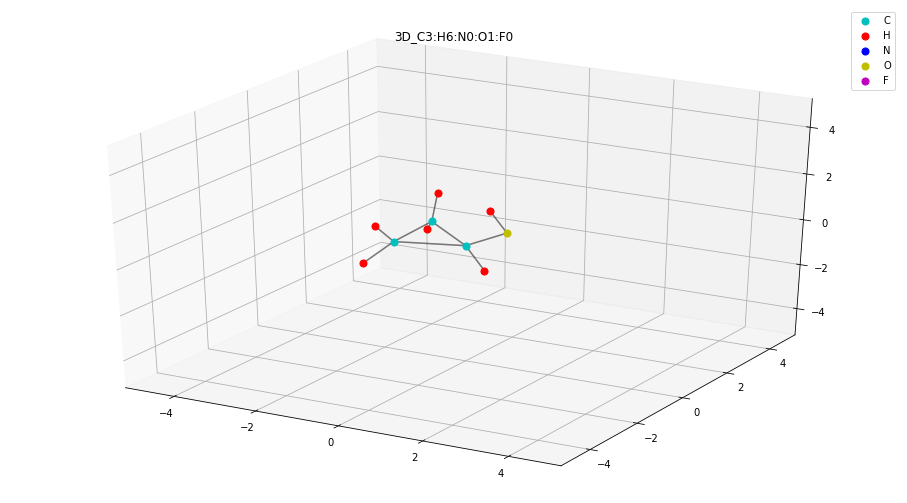

44
24 24.0


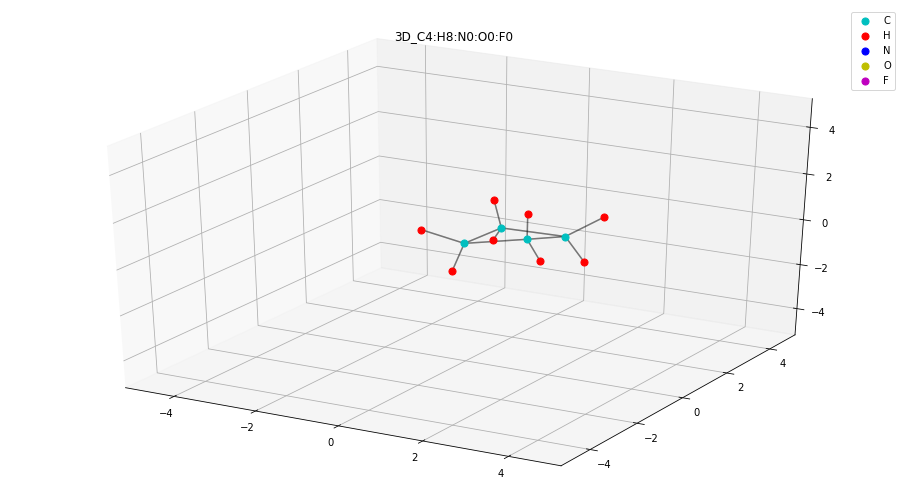

45
20 20.0


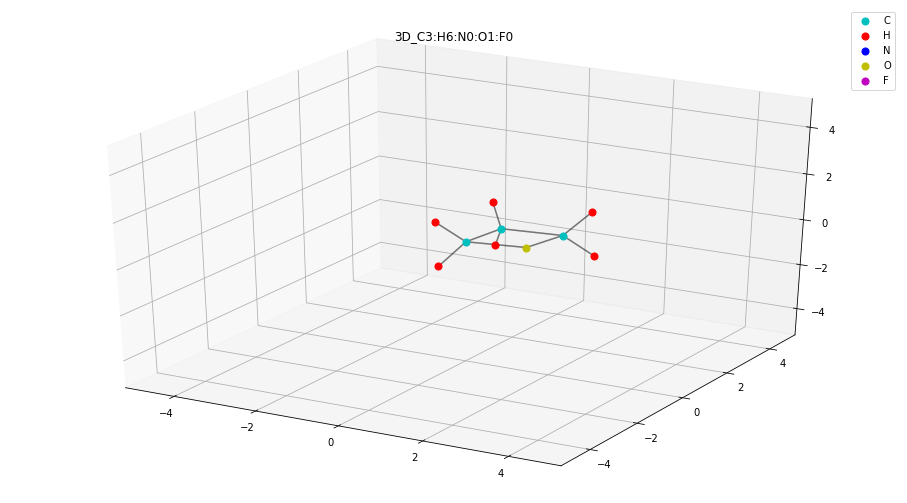

46
24 24.0


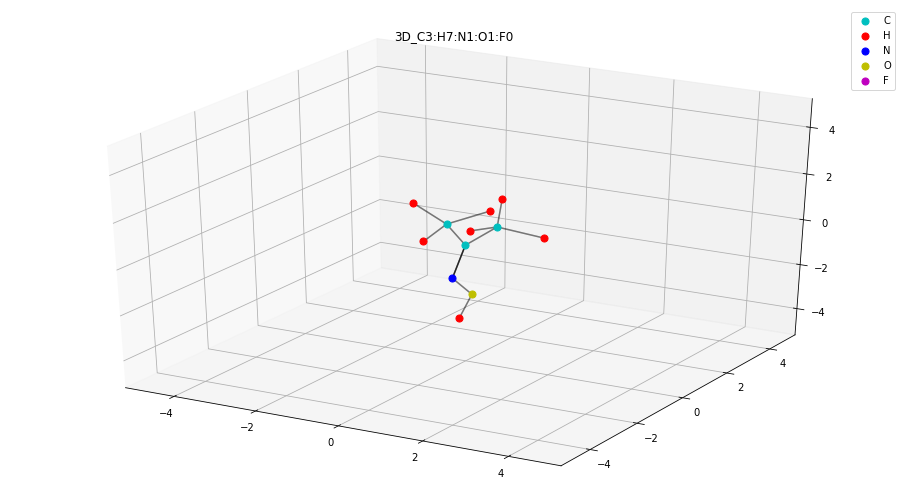

47
24 24.0


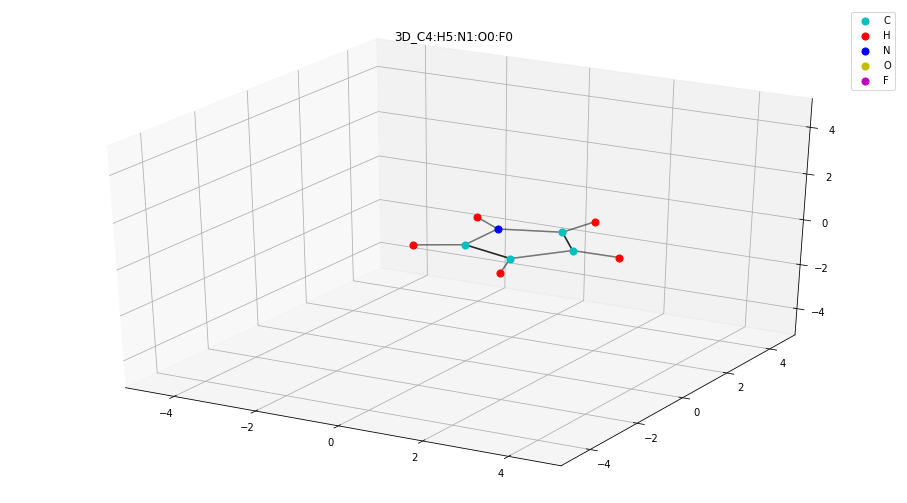

48
22 22.0


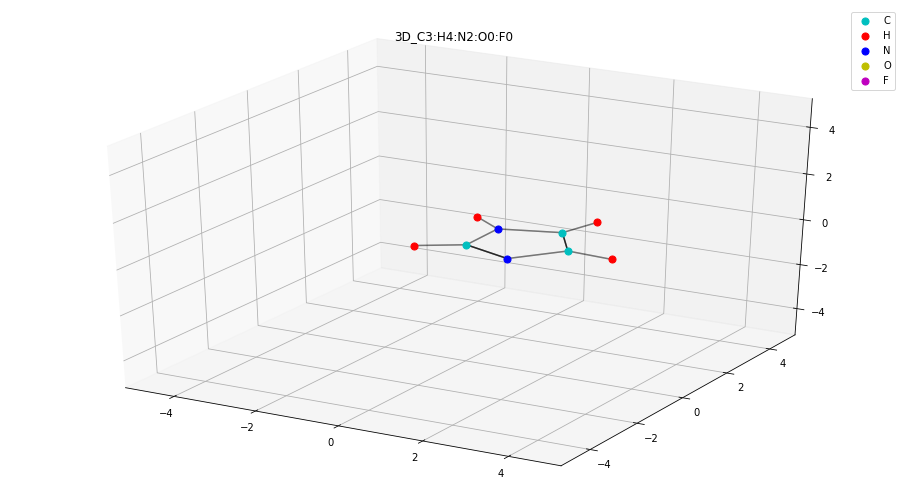

49
22 22.0


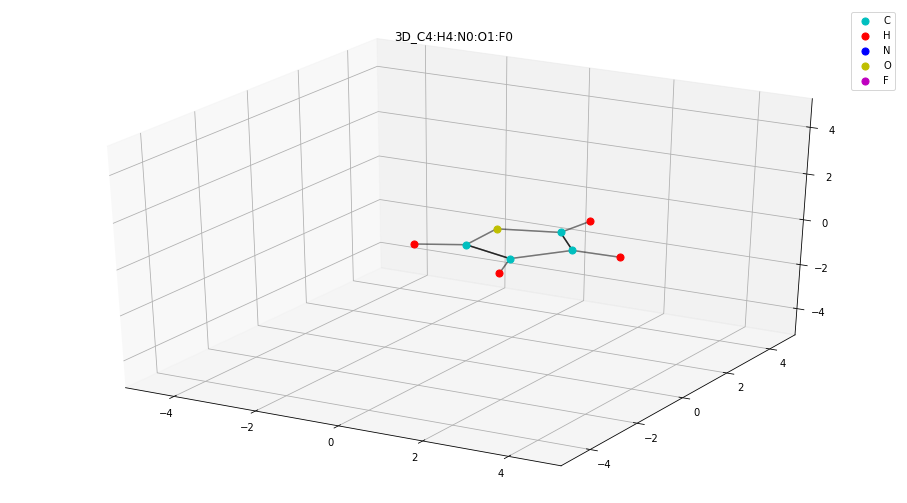

50
20 20.0


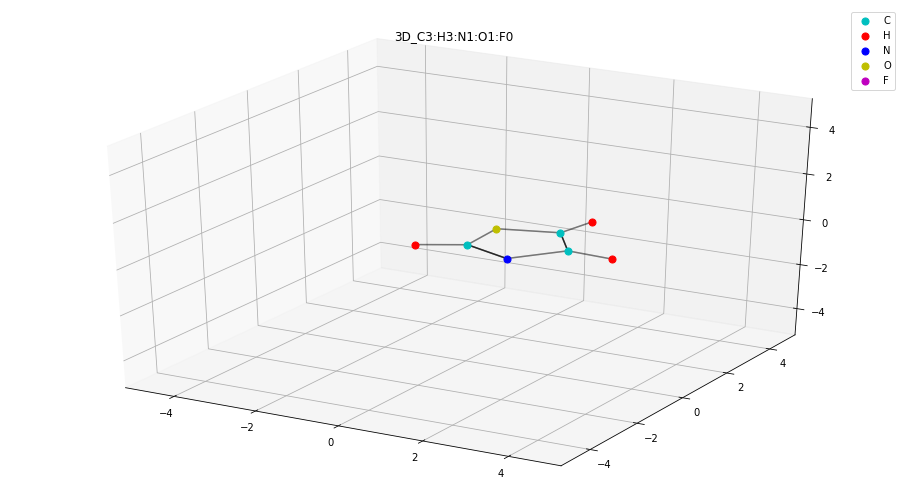

51
32 32.0


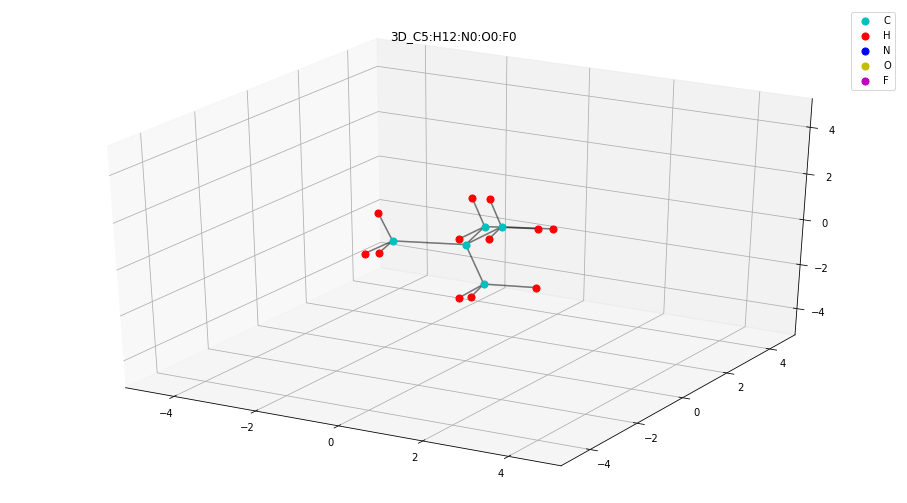

52
28 28.0


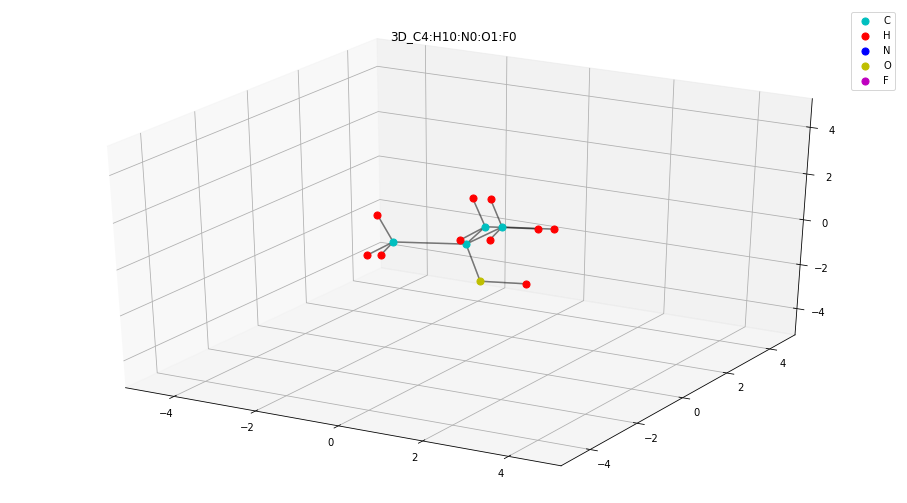

53
22 22.0


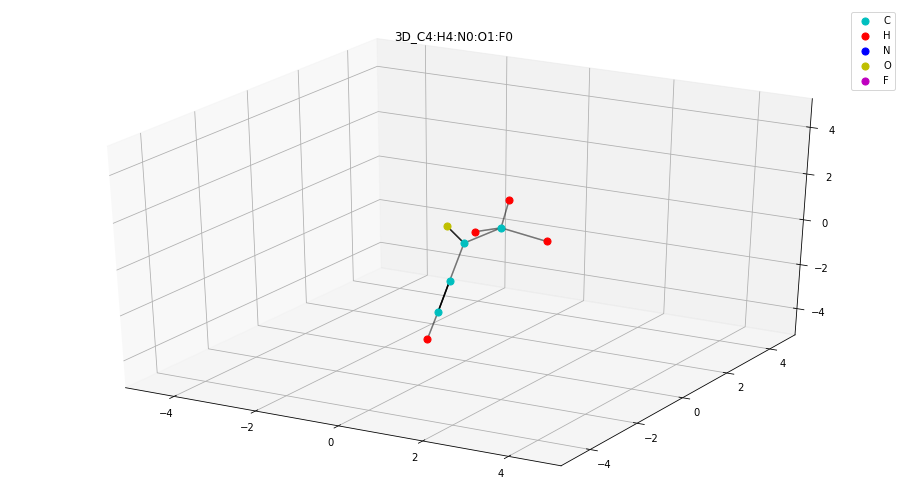

54
20 20.0


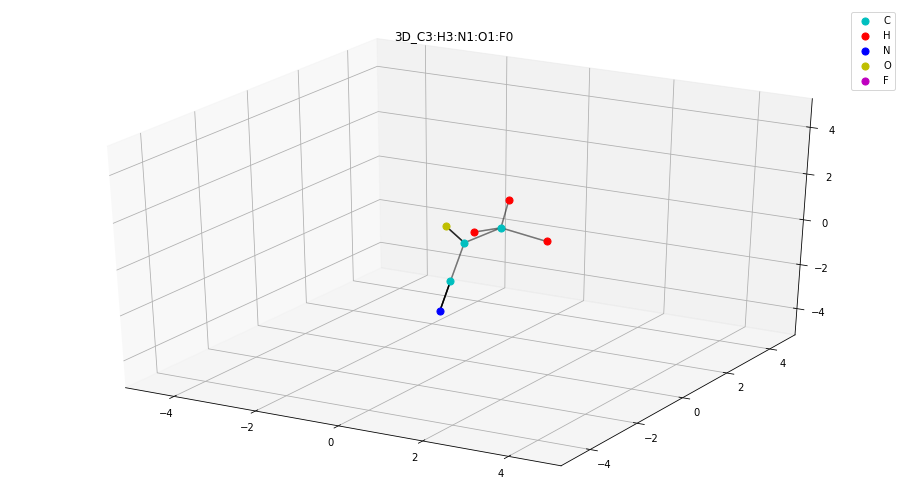

55
20 20.0


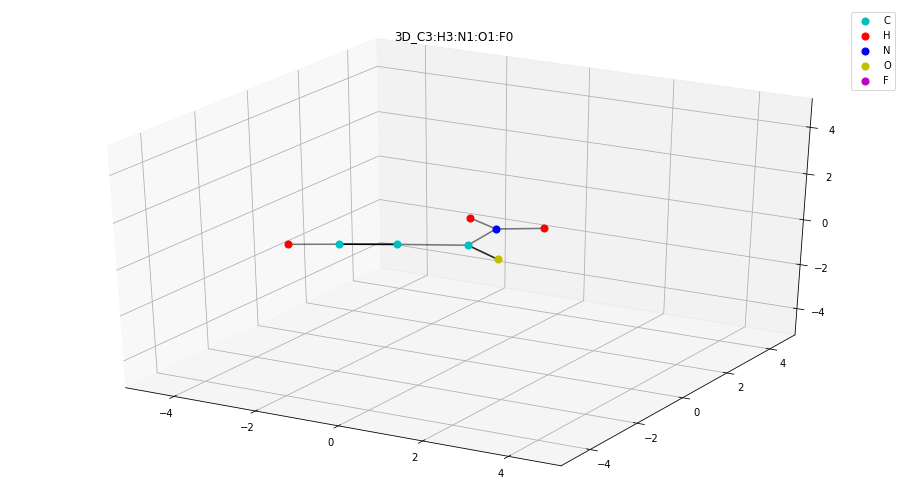

56
20 20.0


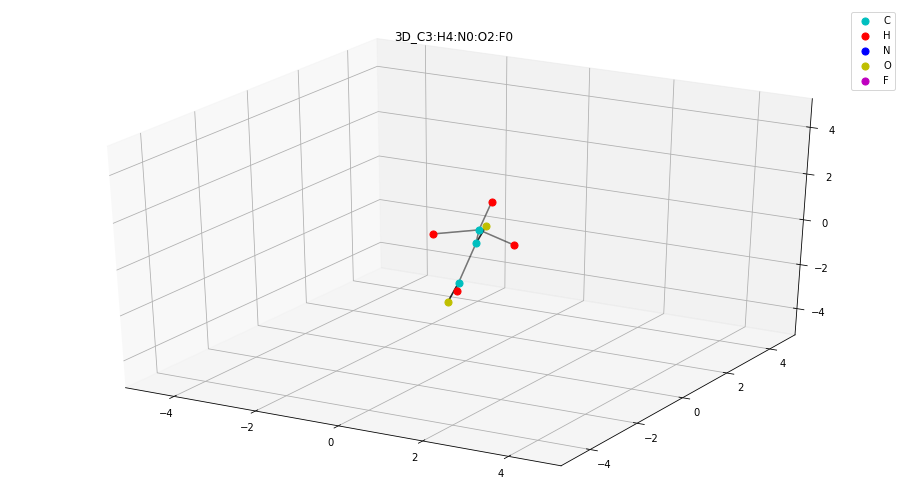

57
18 18.0


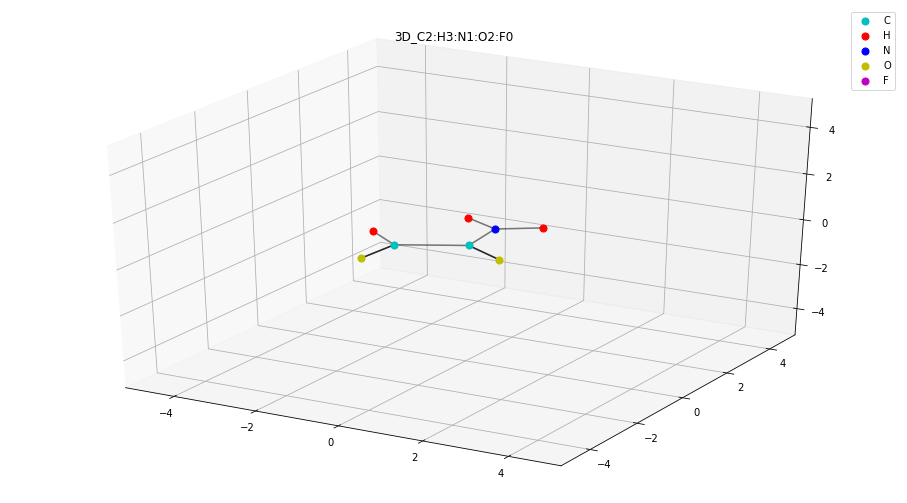

58
28 28.0


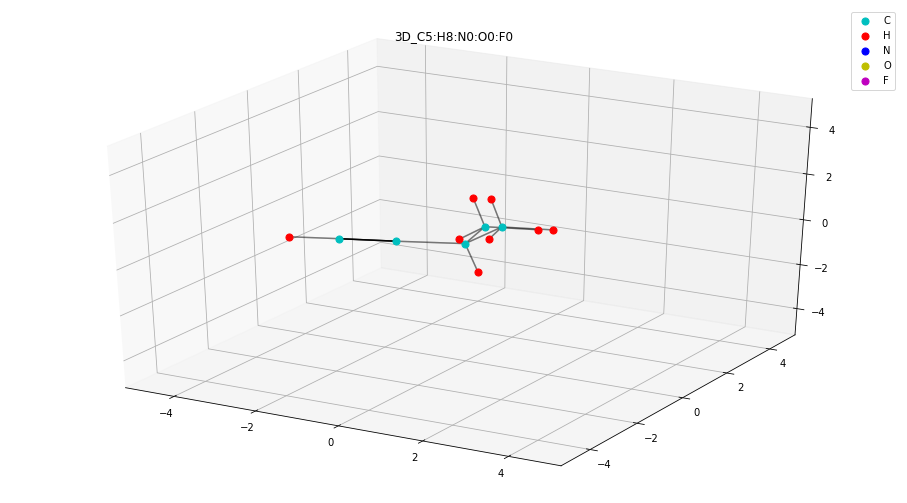

59
26 26.0


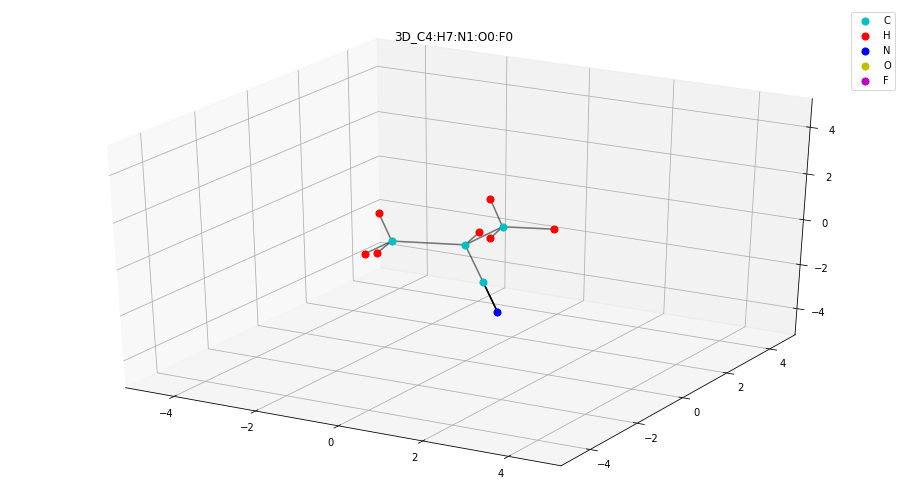

60
24 24.0


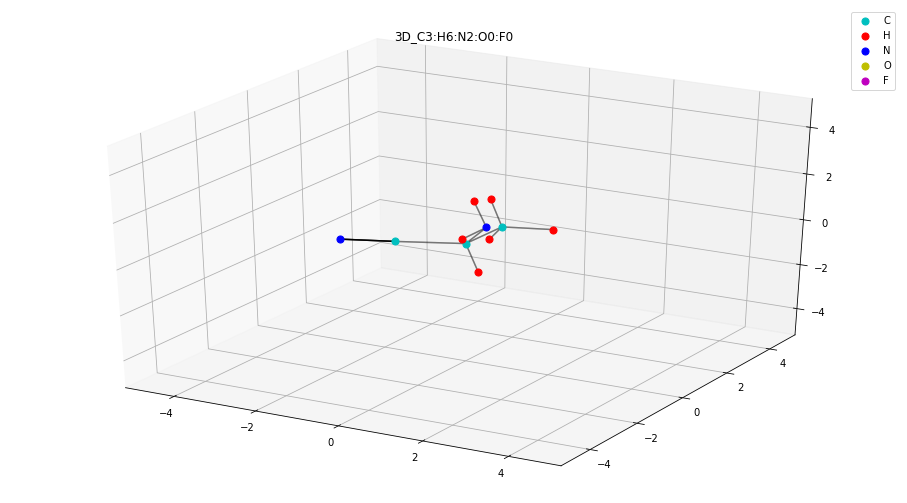

61
24 24.0


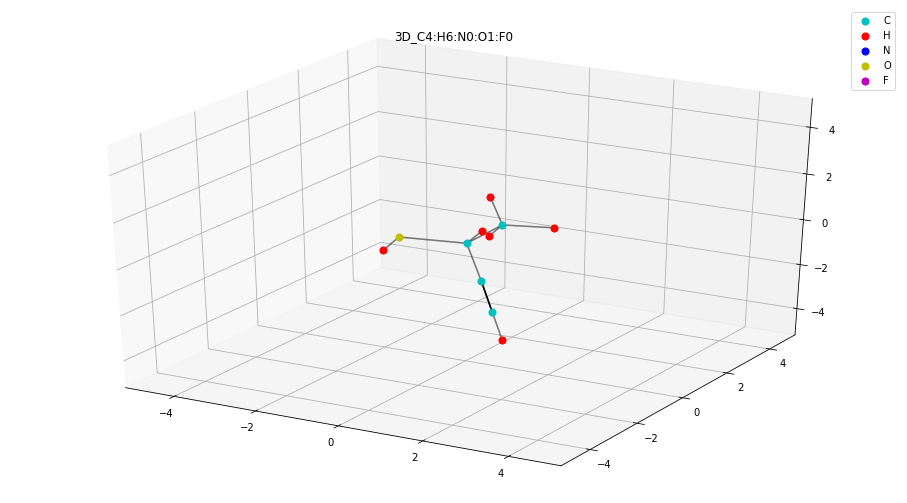

62
22 22.0


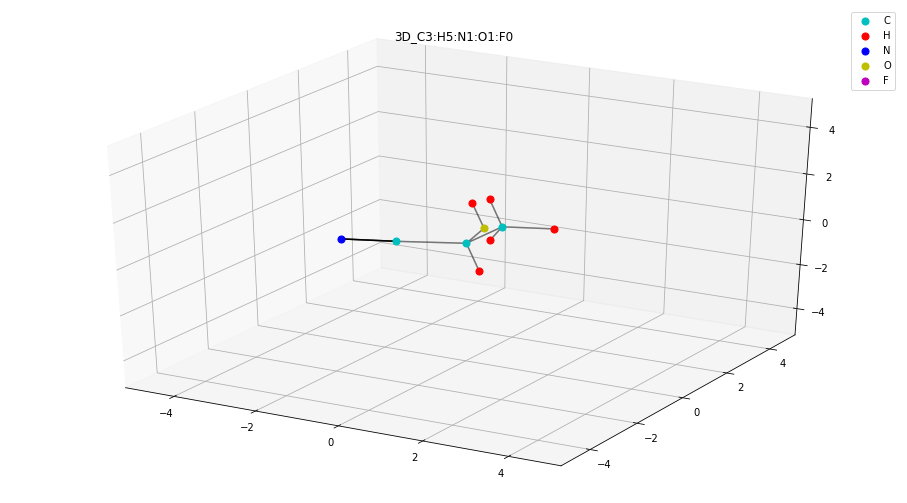

63
26 26.0


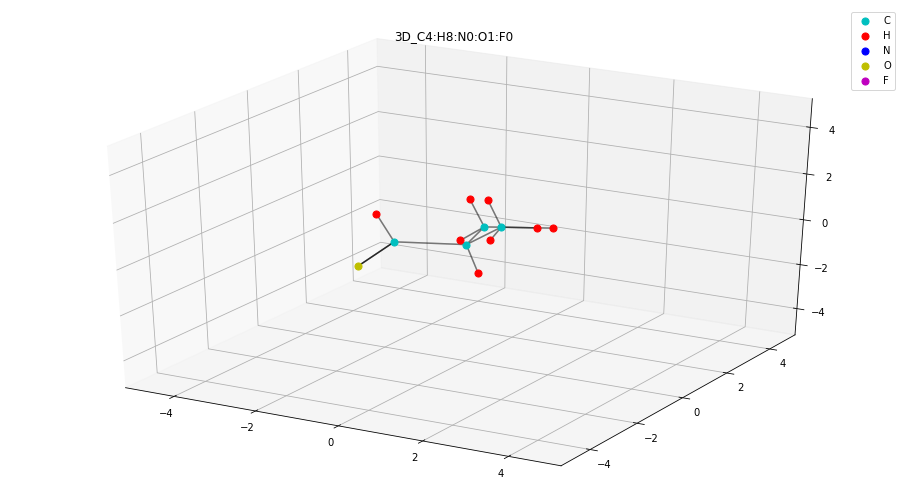

64
22 22.0


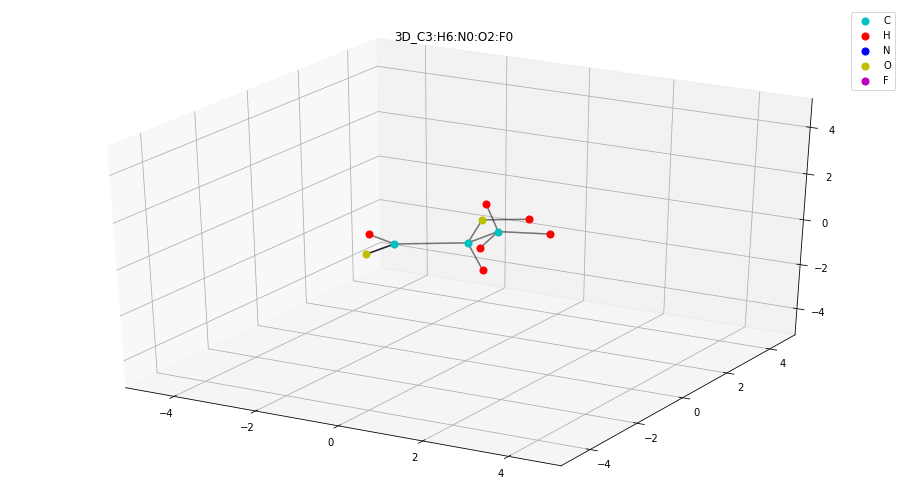

65
24 24.0


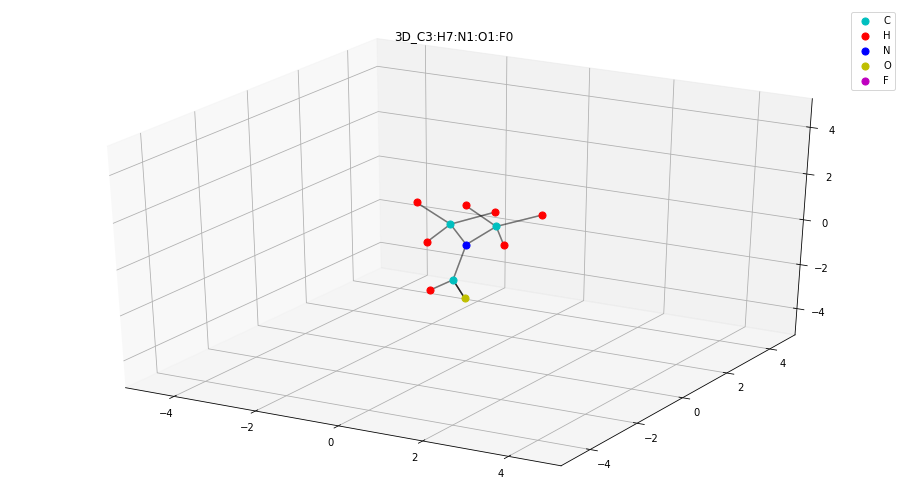

66
22 22.0


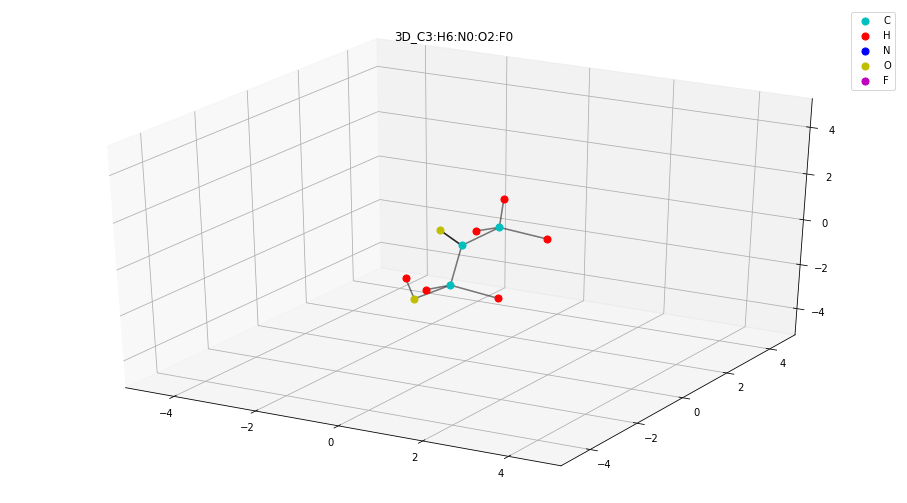

67
26 26.0


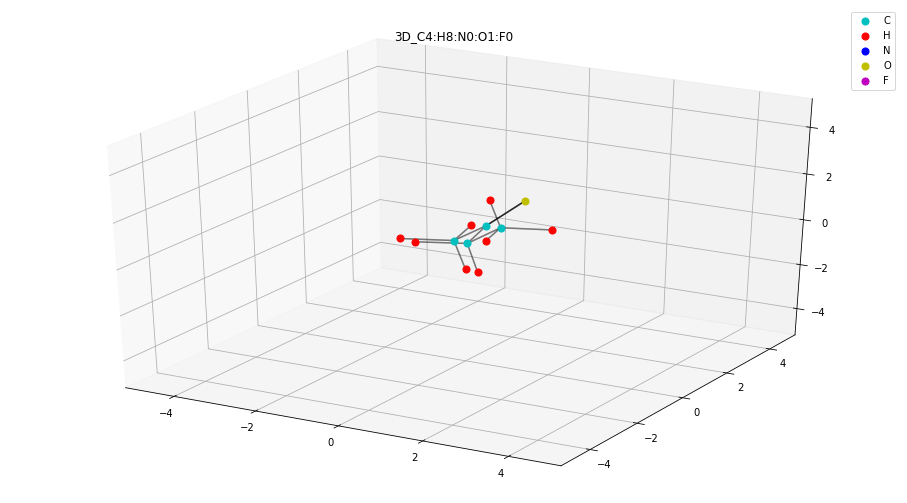

68
24 24.0


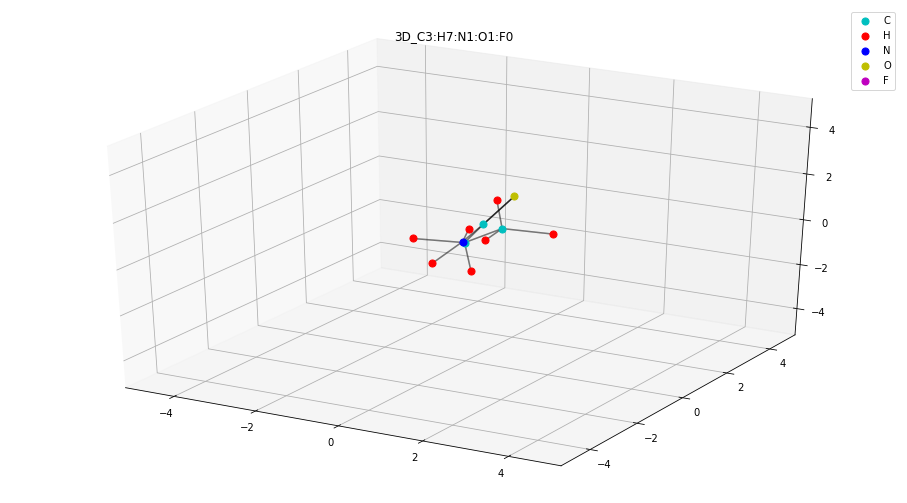

69
24 24.0


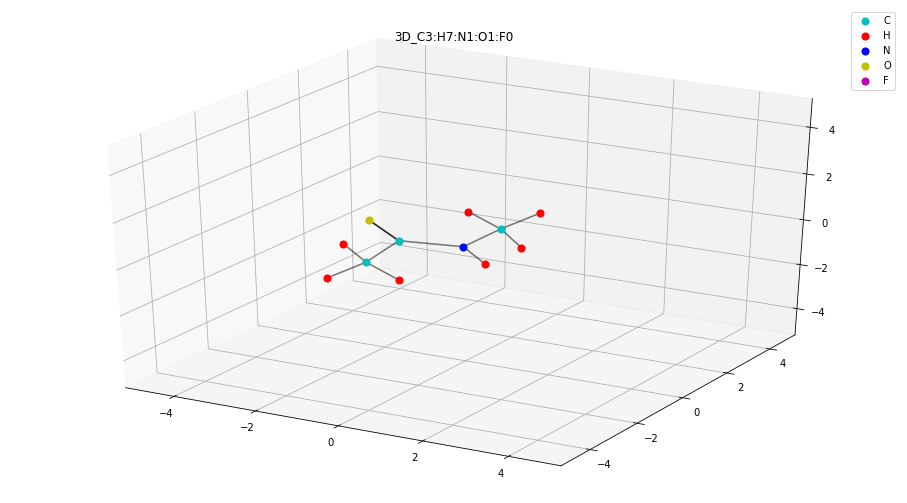

70
22 22.0


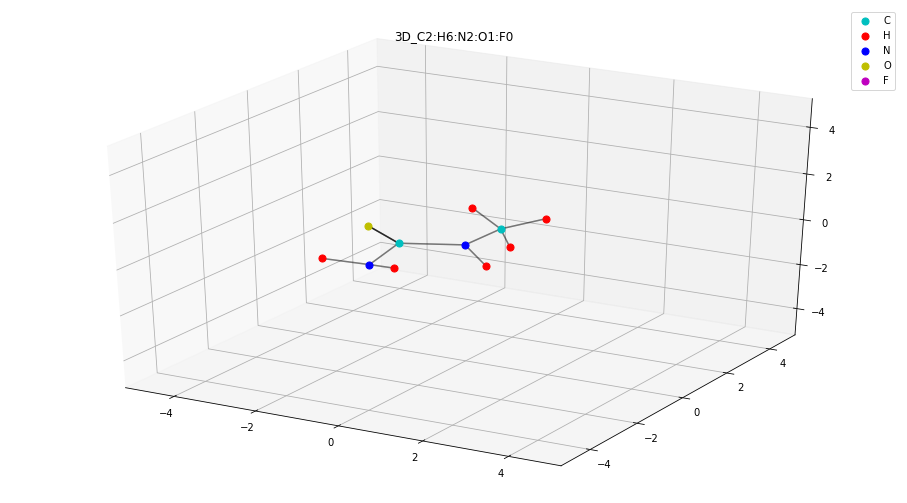

71
24 24.0


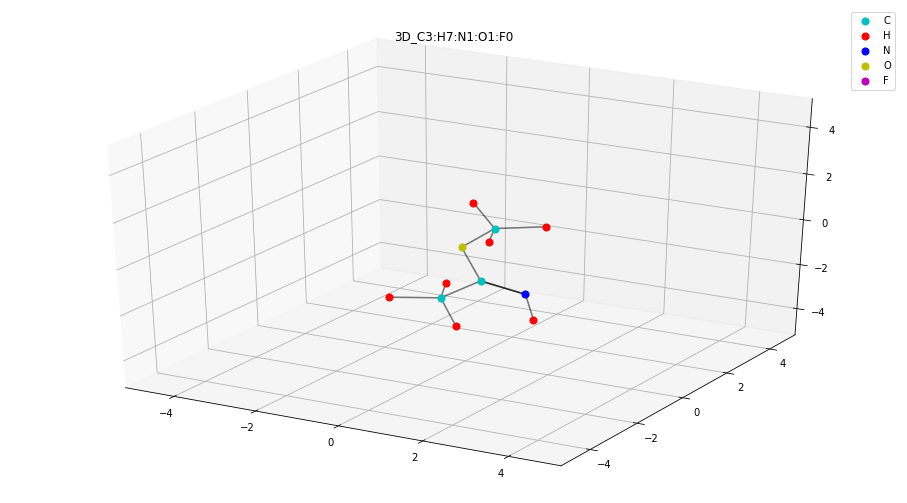

72
22 22.0


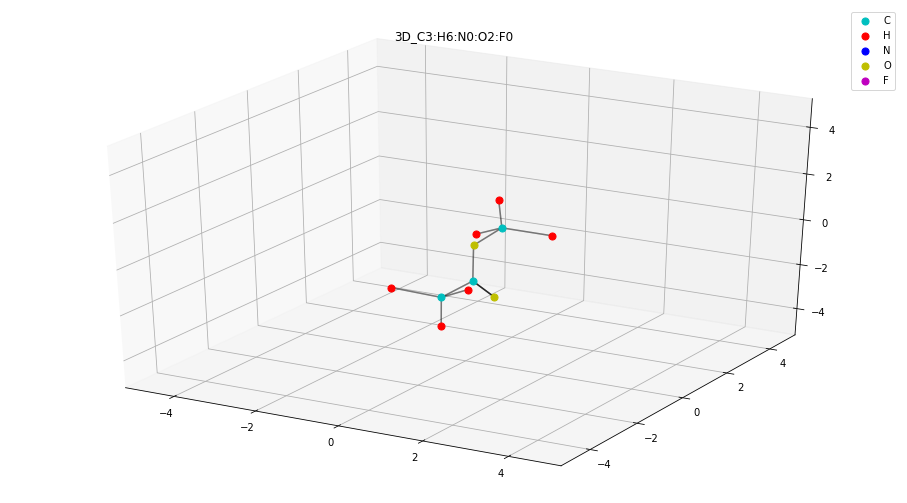

73
20 20.0


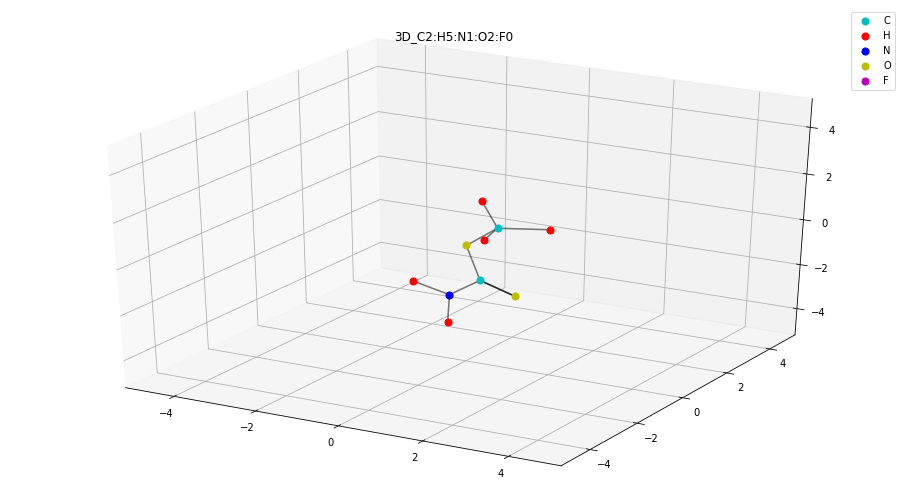

74
20 20.0


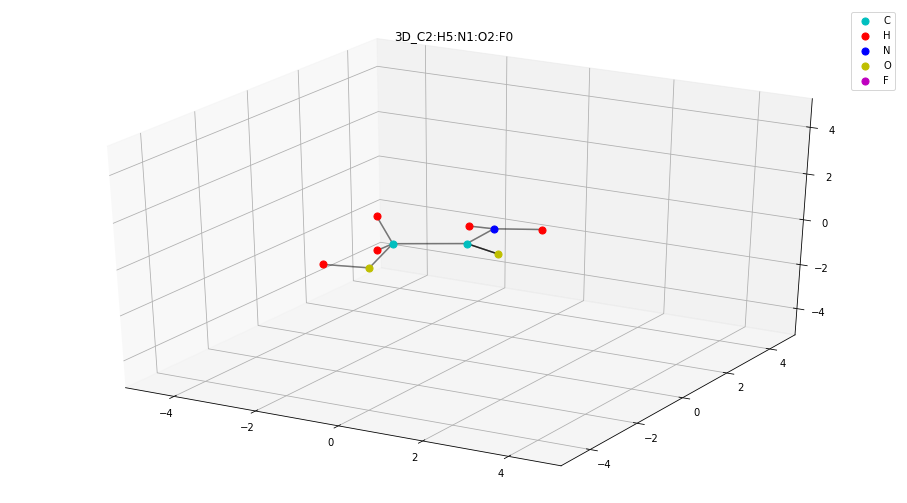

75
28 28.0


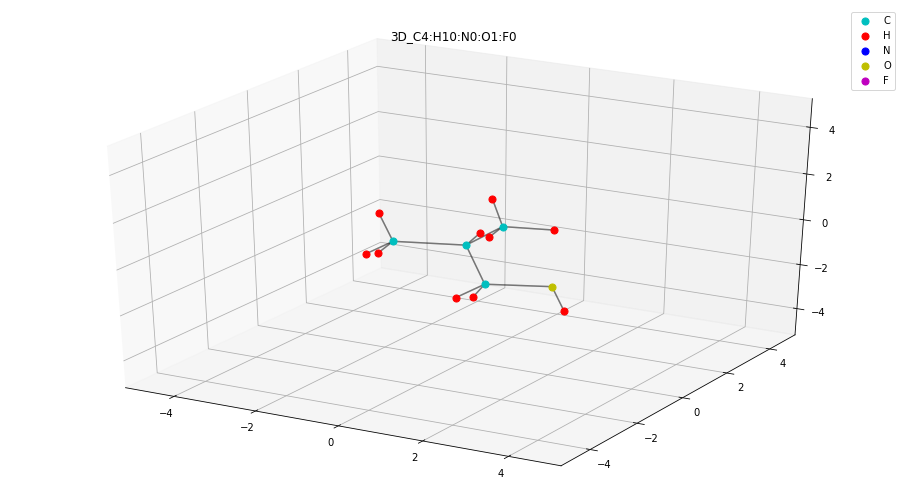

76
24 24.0


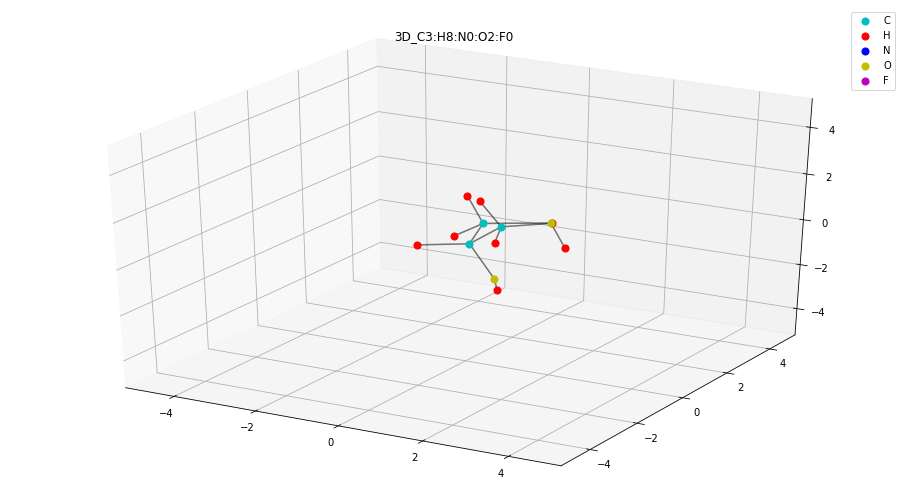

77
32 32.0


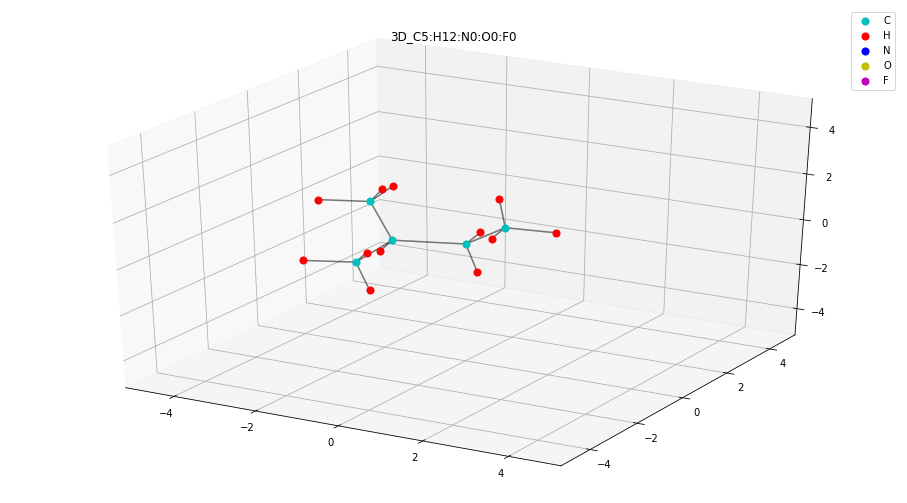

78
28 28.0


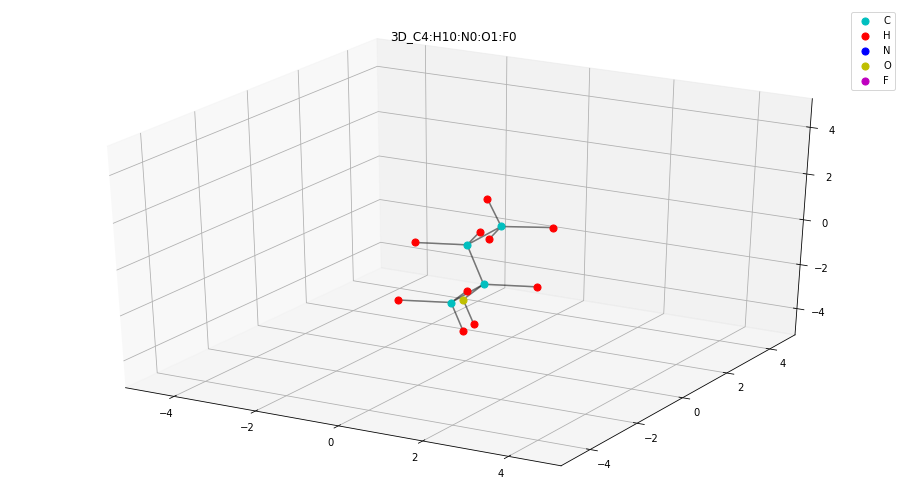

79
28 28.0


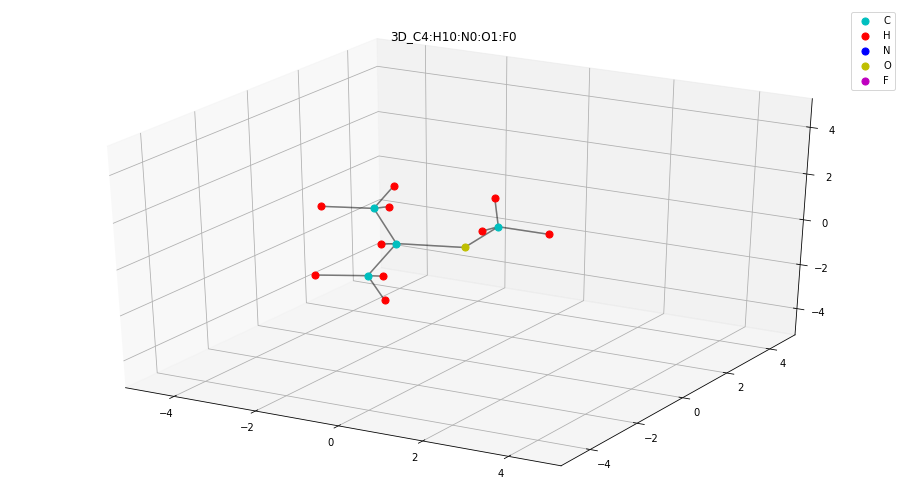

80
30 30.0


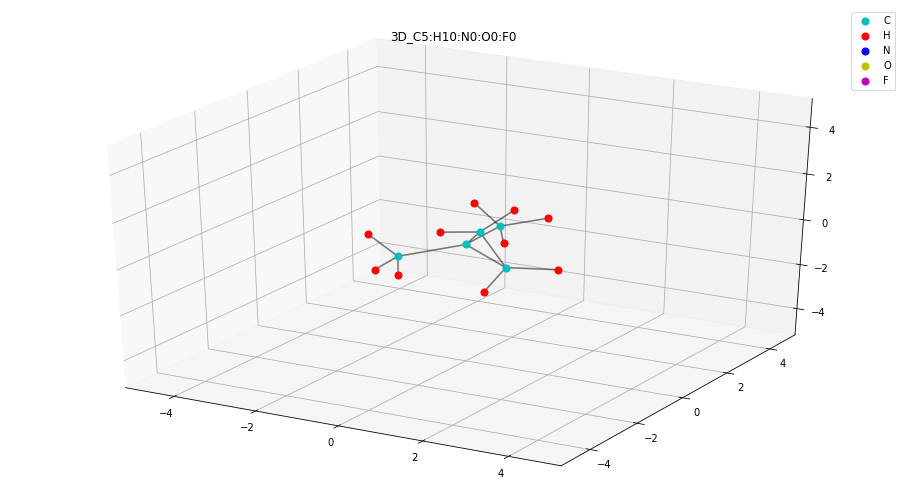

81
26 26.0


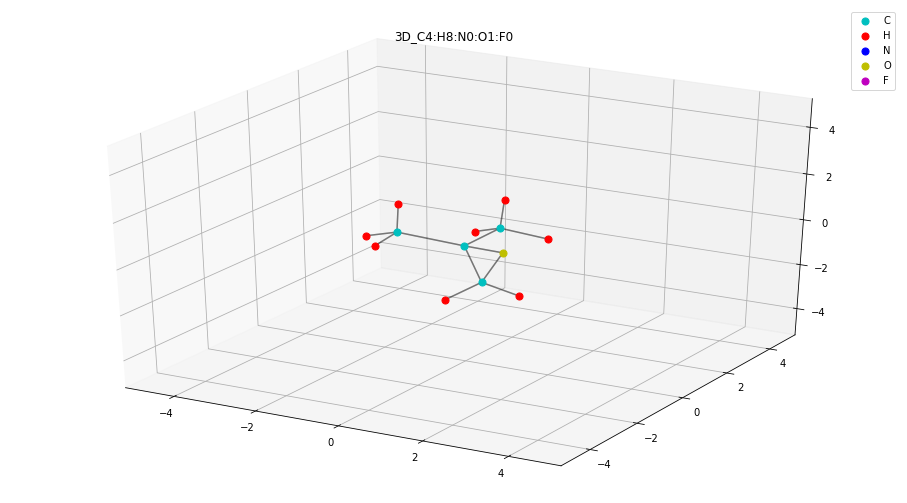

82
26 26.0


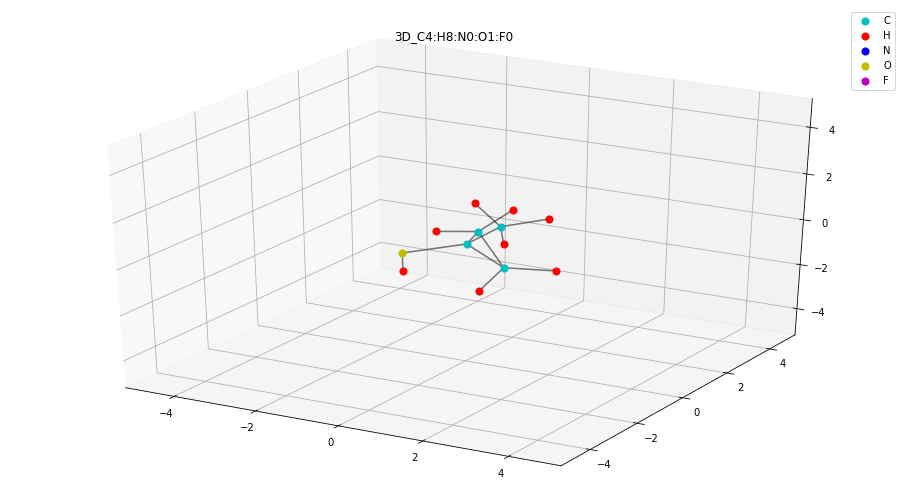

83
22 22.0


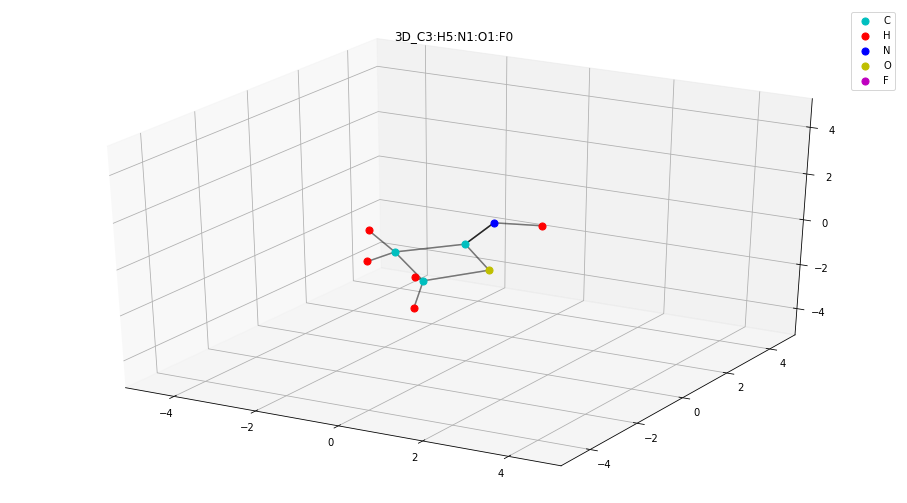

84
24 24.0


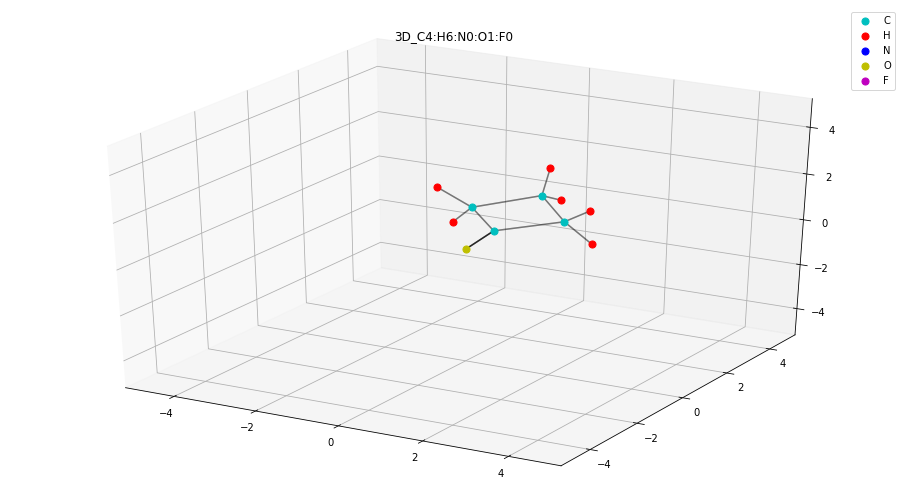

85
22 22.0


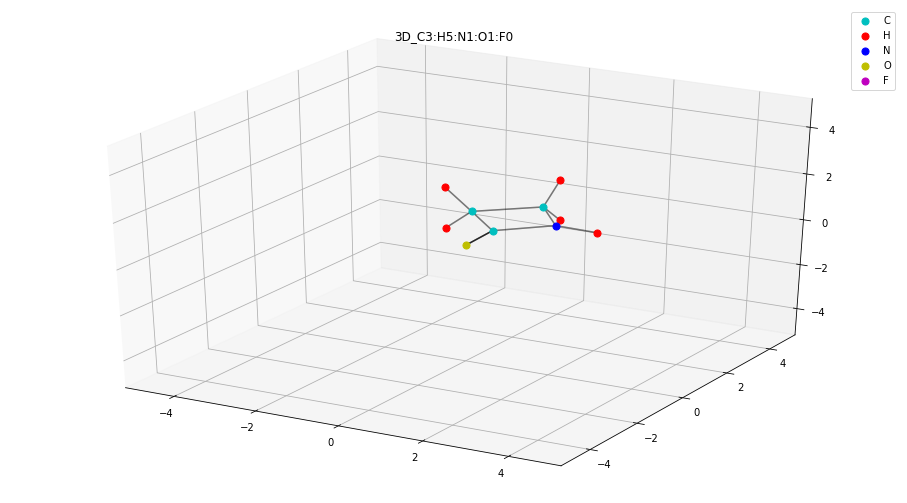

86
20 20.0


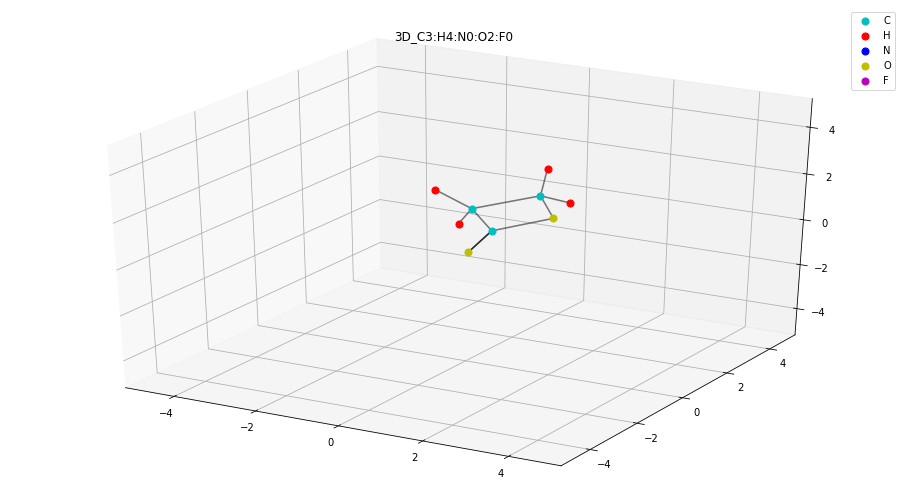

87
22 22.0


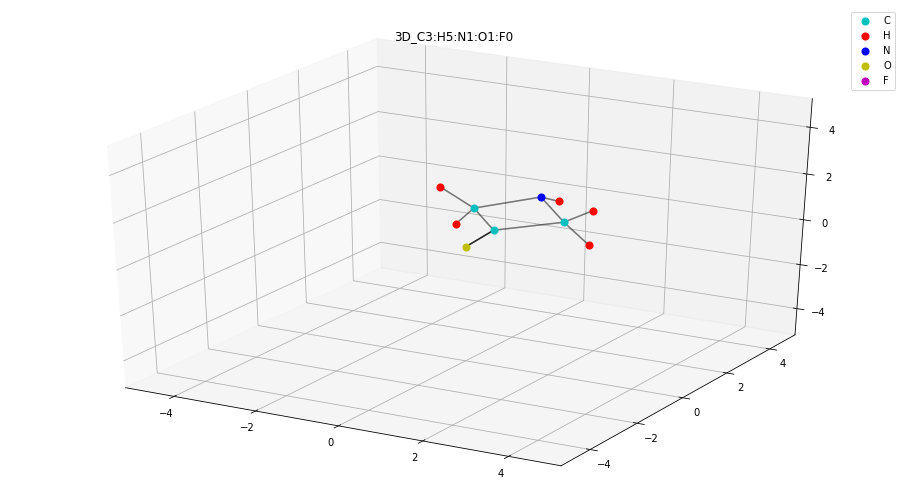

88
20 20.0
20 20.0


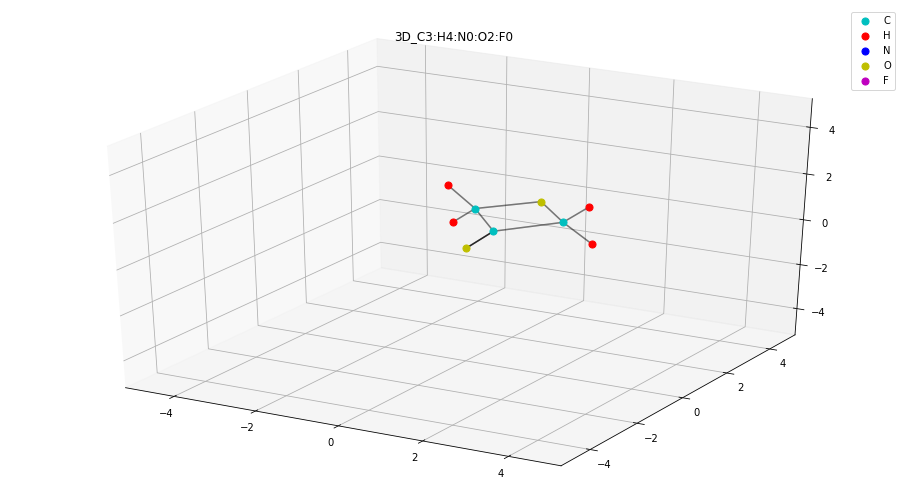

89
30 30.0


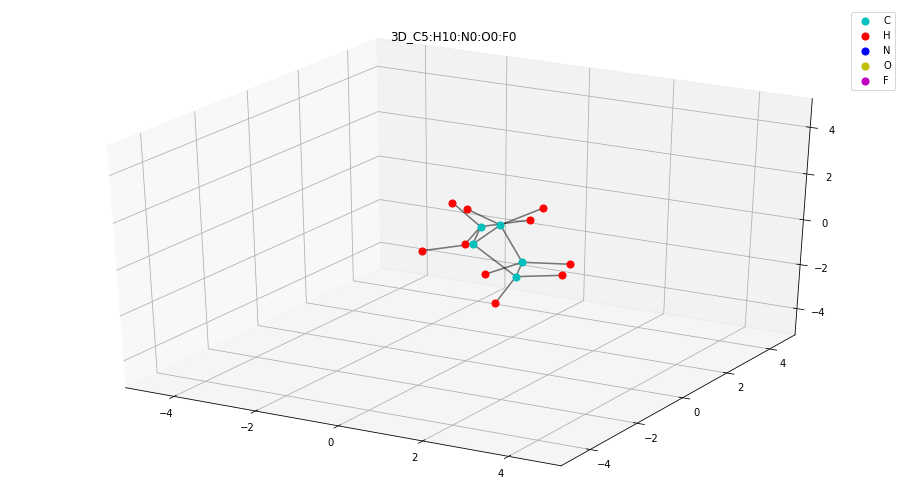

90
26 26.0


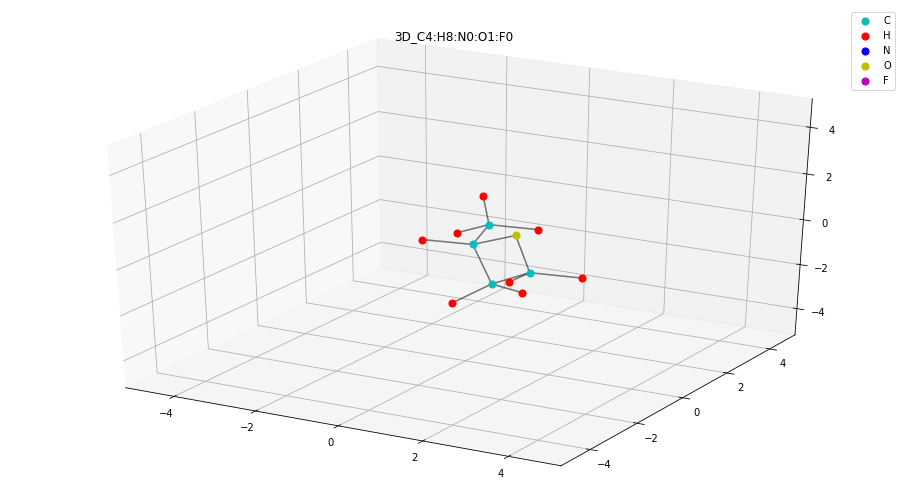

91
26 26.0
26 26.0


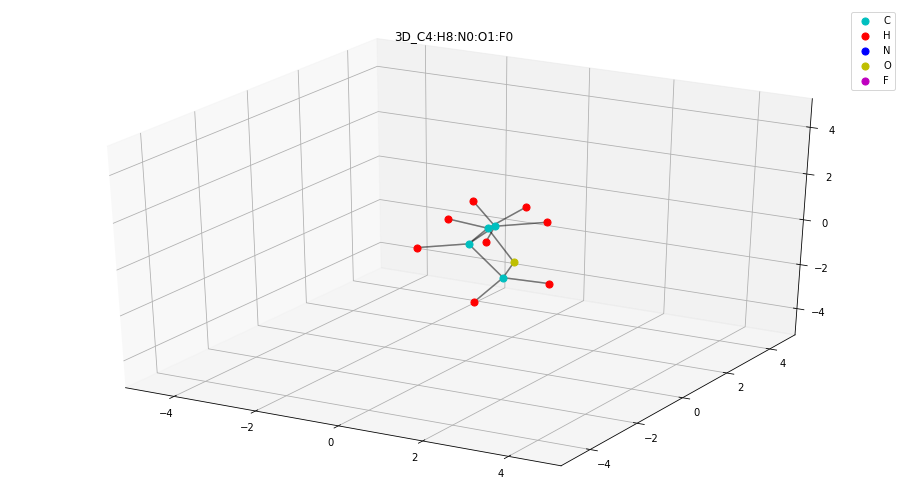

92
26 26.0
26 26.0
26 26.0


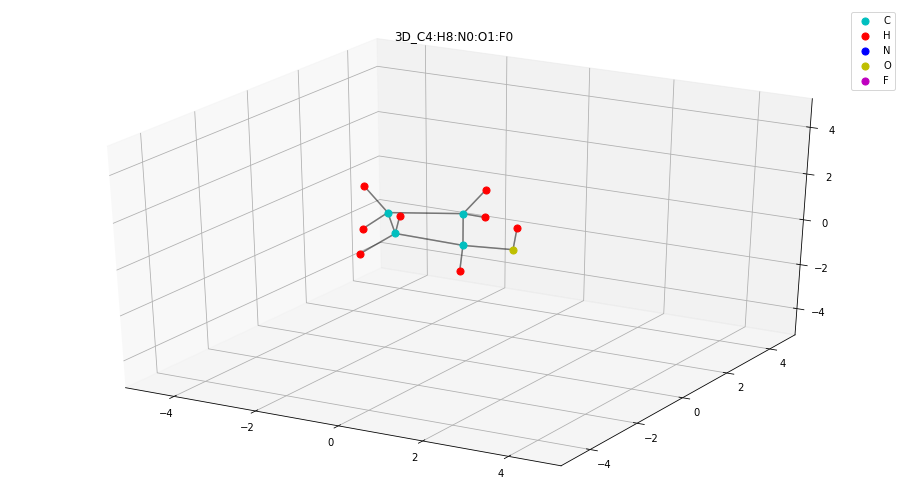

93
22 22.0
22 22.0


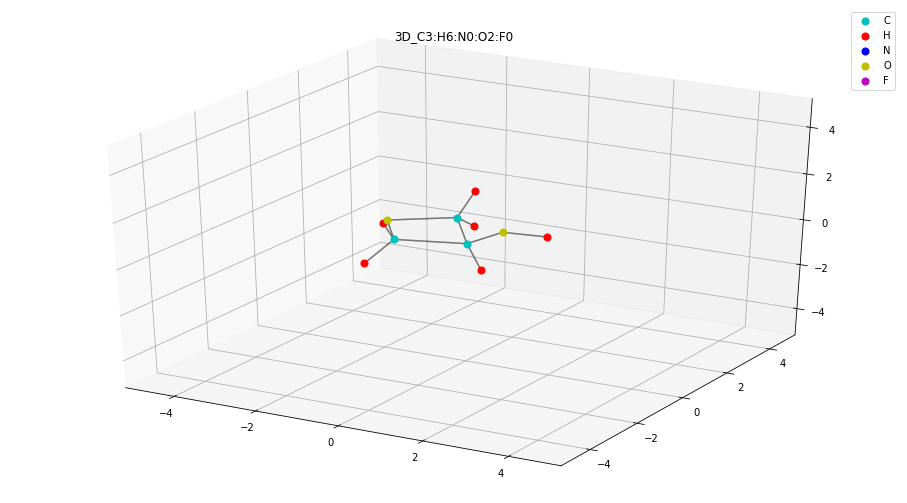

94
30 30.0


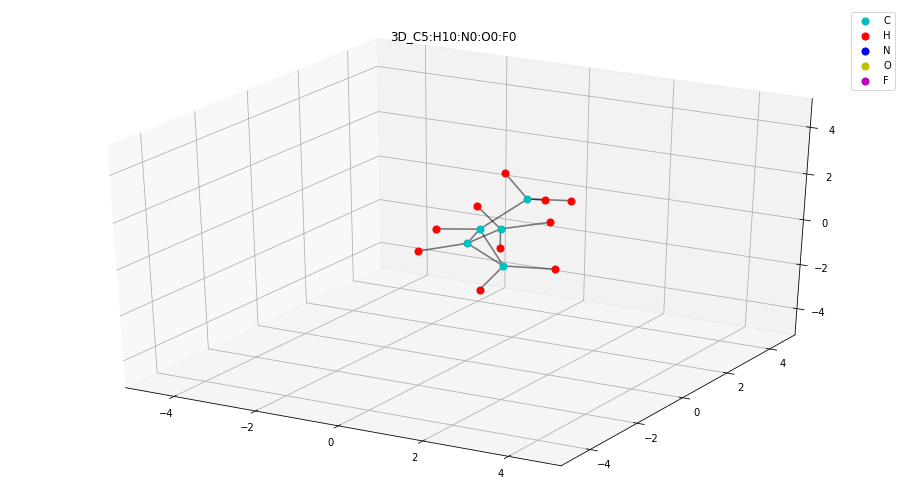

95
26 26.0


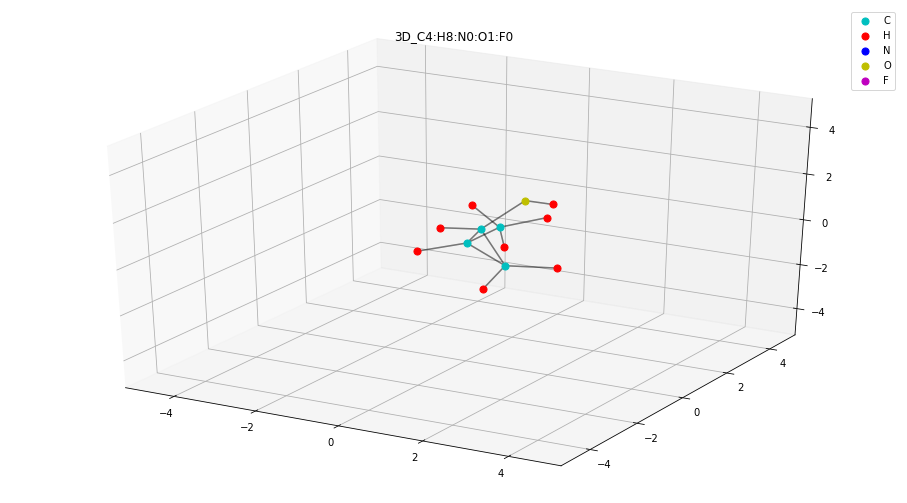

96
28 28.0


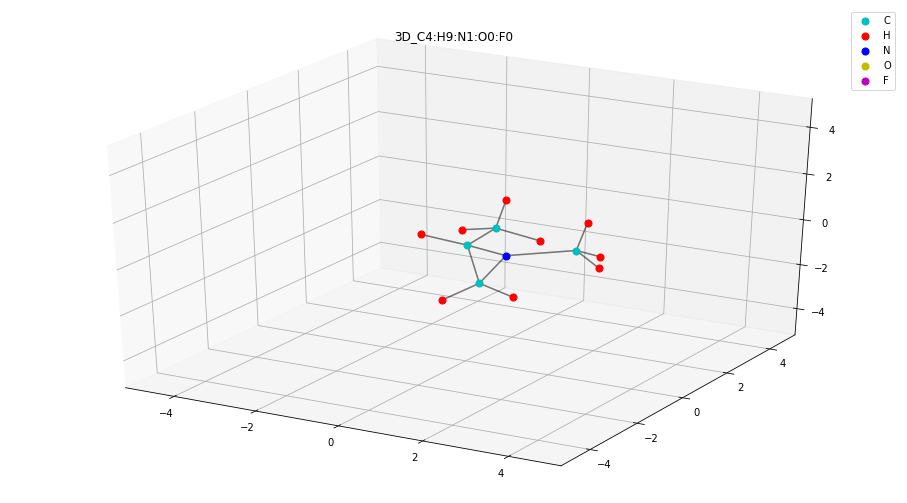

97
26 26.0


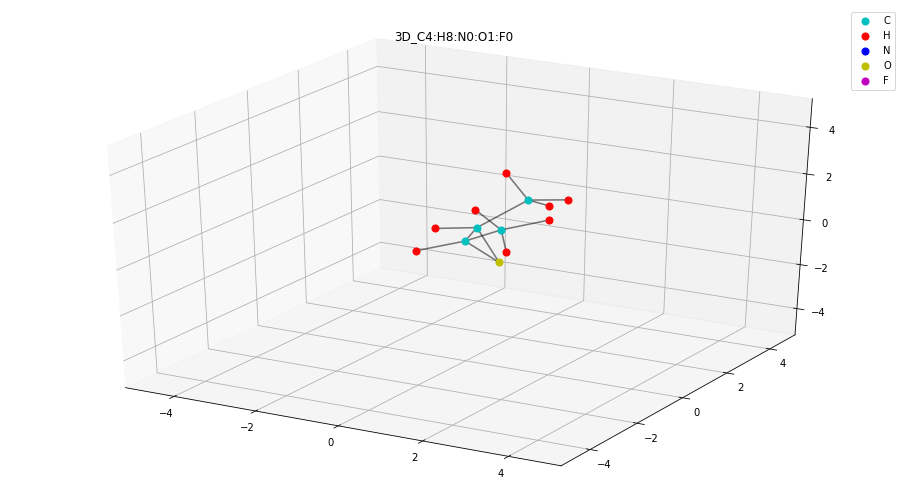

98
22 22.0


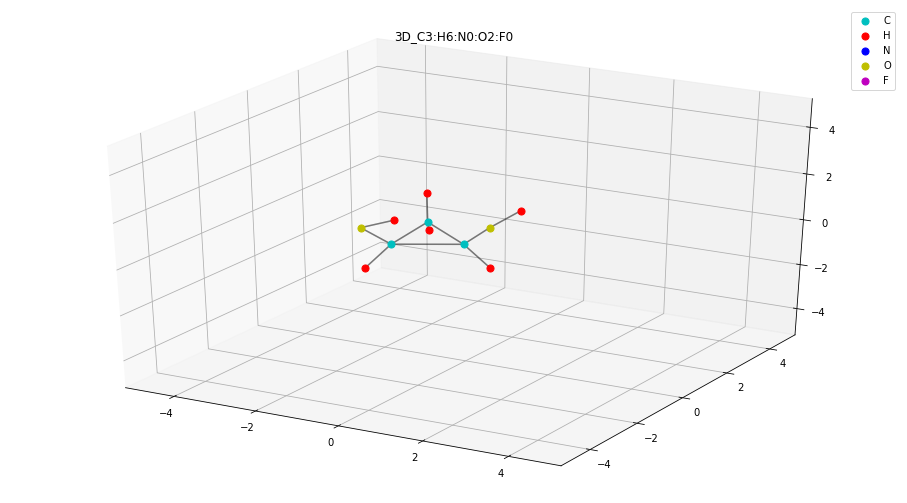

99
28 28.0


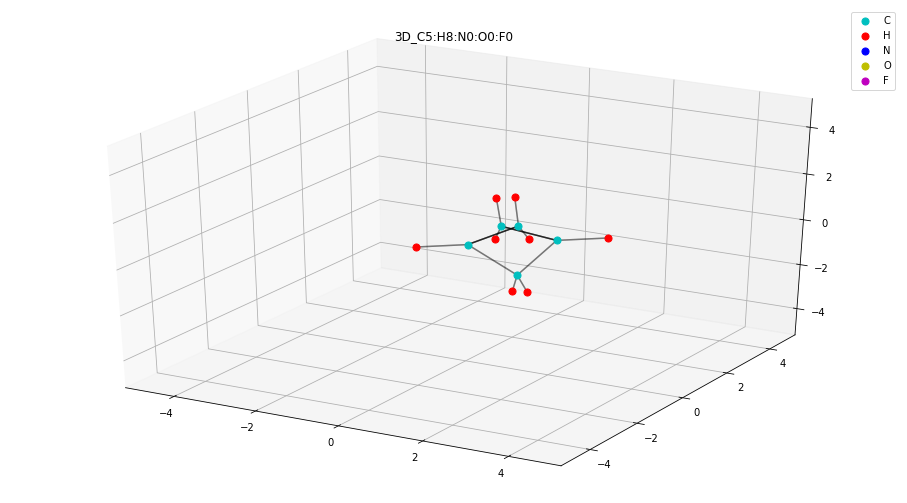

100
24 24.0


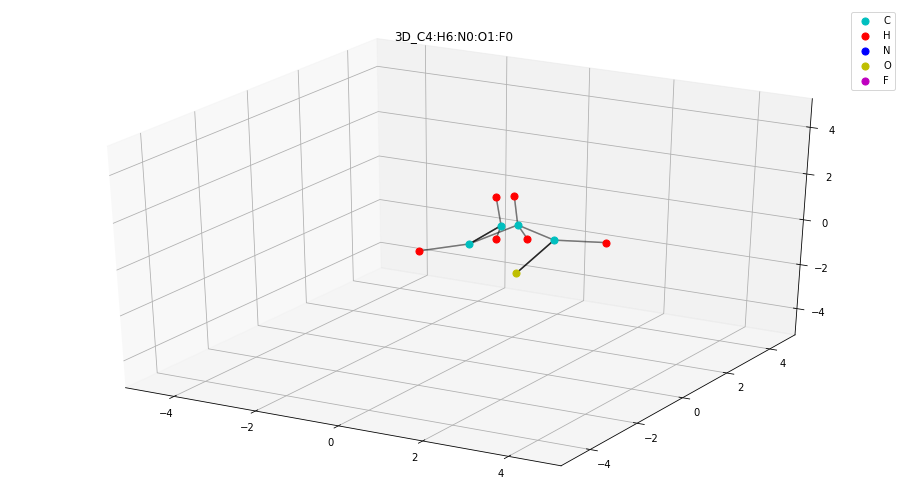

101
24 24.0


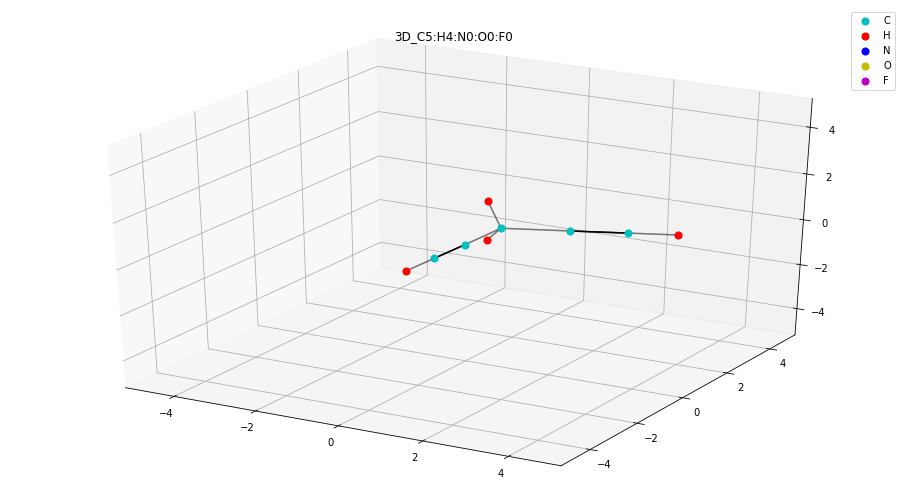

In [20]:
for i, structure in enumerate(structures):
    print(i)
    structure, name2id, id2name, edges, atom_count = get_edges(structure)
    print_3Dstructure(structure, name2id, id2name, edges, atom_count)
    if i > 100:
        break